# Redes Neurais - 
## 1ª Lista de Exercícios - Classificação de padrões


Estudante: Laura M. P. Navarro

Base de dados: ionosphere

### Para cada item da lista de exercício, não esqueça de fazer uma análise pertinente dos resultados obtidos.

<h1> Importante! </h1>

1. Fique atento com os hiperparâmetros iniciais desta lista. Dependendo do problema, os valores podem mudar. Para encontrar um conjunto de parâmetros razoáveis, siga o seguinte roteiro: 

        1. Rode os itens 2.1 e 3.1 com os parâmetros iniciais. Se os dois resultados foram igualmente ruins, modifique os parâmetros do item 3.1 até que o resultado seja relativamente melhor que o 2.1.

        2. Após obter esses melhores parâmetros iniciais, rode novamente o item 2.1 com os mesmos hiperparâmetros para uma comparação mais justa. 

2. O resultado de um modelo de Redes Neurais geralmente depende da inicialização de seus pesos. Portanto, para cada questão, obtenha um resultado médio de pelo menos 10 rodadas.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np 
import pandas as pd 
import json
import matplotlib.pyplot as plt 
import seaborn as sns 
from time import sleep
import requests

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader 

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from utils import CustomDataset, transform_data, plot_confusion_matrix
from model_utils import train


In [2]:
class NeuralNetwork(torch.nn.Module):
  '''
  Objeto criado para facilitar o desenvolvimento dos scripts das aulas práticas.
  Opção alternativa à criação externa fdo modelo. Basicamente serve como um 
  'agregador'  de trechos comuns para a criação do modelo. Por exemplo, ao invés
  de gastar n+1 linhas para a criação de um modelo com n camadas, podemos criar 
  o mesmo modelo com apenas uma linha.
  
  Parâmetros de entrada: 
  - hidden_neurons: Lista com a quantidade de neurônios na camada escondida. 
  - hidden_activation: Função de ativação para cada camada escondida. Aceita 
  como parâmetro string ou lista. Caso o parâmetro receba string, então a mesma
  função de ativação é utilizada para todas as camadas escondidas. Caso seja uma 
  lista, cada camada terá sua propria função de ativação definida pela lista.
  - output_activation: Função de ativação para a camada de saída.
  - lr: Taxa de aprendizado
  - n_input: Tamanho do vetor de entrada.
  - n_output: Saída do modelo.
  '''
  def __init__(self,hidden_neurons = 4, hidden_activation = 'relu', output_activation='softmax', lr = 0.05, n_input = 1, n_output = 1):
    # create model
    super(NeuralNetwork, self).__init__()

    self.activations = {'relu': nn.ReLU(), 'sigmoid':nn.Sigmoid(), 'softmax':nn.Softmax()}

    self.fc1 = nn.Linear(n_input, hidden_neurons)
    self.ha = self.activations[hidden_activation]
    self.fc2 = nn.Linear(hidden_neurons, n_output)
    #self.out = self.activations[output_activation]
    
    #self.out = nn.Sigmoid() #Para o caso binário
  def forward(self,x):
    h = self.fc1(x)
    h1 = self.ha(h) 
    y = self.fc2(h1) 
    #y = self.out(h2)
    return y

  def predict(self, x, binary=True):
    y_hat = self.forward(x)

    if binary:
      y_pred = torch.round(torch.sigmoid(y_hat))
      y_pred = y_pred.detach().numpy()
    else:
      y_pred = torch.argmax(y_hat, dim=1)

    return y_pred

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Preparação dos dados

Não esqueça de verificar o path para a pasta. Mude também o filename, de acordo com a base de dados.

In [4]:
dataset_name = 'ionosphere' #nome correspondete ao dataset asignado
dataset_path = "data\c_ionosphere.csv"
dataset = pd.read_csv(dataset_path)
dataset.head()

info_0  info_1   info_2   info_3   info_4   info_5   info_6   info_7  \
0       1       0  0.99539 -0.05889  0.85243  0.02306  0.83398 -0.37708   
1       1       0  1.00000 -0.18829  0.93035 -0.36156 -0.10868 -0.93597   
2       1       0  1.00000 -0.03365  1.00000  0.00485  1.00000 -0.12062   
3       1       0  1.00000 -0.45161  1.00000  1.00000  0.71216 -1.00000   
4       1       0  1.00000 -0.02401  0.94140  0.06531  0.92106 -0.23255   

    info_8   info_9  ...  info_25  info_26  info_27  info_28  info_29  \
0  1.00000  0.03760  ... -0.51171  0.41078 -0.46168  0.21266 -0.34090   
1  1.00000 -0.04549  ... -0.26569 -0.20468 -0.18401 -0.19040 -0.11593   
2  0.88965  0.01198  ... -0.40220  0.58984 -0.22145  0.43100 -0.17365   
3  0.00000  0.00000  ...  0.90695  0.51613  1.00000  1.00000 -0.20099   
4  0.77152 -0.16399  ... -0.65158  0.13290 -0.53206  0.02431 -0.62197   

   info_30  info_31  info_32  info_33  target  
0  0.42267 -0.54487  0.18641 -0.45300       g  
1 -0.16626 -0.06288 -0.13738 -0.02447       b  
2  0.60436 -0.24180  0.56045 -0.38238       g  
3  0.25682  1.00000 -0.32382  1.00000       b  
4 -0.05707 -0.59573 -0.04608 -0.65697       g  

[5 rows x 35 columns]

In [5]:
with open("data/ionosphere/data_info.json", "r") as f:
    info = json.load(f)

In [6]:
for col, k in info.items():
    if k == 'categorical':
        dataset[col] = dataset[col].astype(object)

In [7]:
for i in dataset.dtypes.items():
    print(i)

('info_0', dtype('int64'))
('info_1', dtype('int64'))
('info_2', dtype('float64'))
('info_3', dtype('float64'))
('info_4', dtype('float64'))
('info_5', dtype('float64'))
('info_6', dtype('float64'))
('info_7', dtype('float64'))
('info_8', dtype('float64'))
('info_9', dtype('float64'))
('info_10', dtype('float64'))
('info_11', dtype('float64'))
('info_12', dtype('float64'))
('info_13', dtype('float64'))
('info_14', dtype('float64'))
('info_15', dtype('float64'))
('info_16', dtype('float64'))
('info_17', dtype('float64'))
('info_18', dtype('float64'))
('info_19', dtype('float64'))
('info_20', dtype('float64'))
('info_21', dtype('float64'))
('info_22', dtype('float64'))
('info_23', dtype('float64'))
('info_24', dtype('float64'))
('info_25', dtype('float64'))
('info_26', dtype('float64'))
('info_27', dtype('float64'))
('info_28', dtype('float64'))
('info_29', dtype('float64'))
('info_30', dtype('float64'))
('info_31', dtype('float64'))
('info_32', dtype('float64'))
('info_33', dtype('float

## Parte I - Compreensão do problema e análise de variáveis

Total: 2,0 pts.


### 1)	Observe a base de dados do problema. Existem variáveis que podem ser eliminadas do dataset? Justifique.

#### Rascunho

In [8]:
dataset.info()
dataset.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 35 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   info_0   351 non-null    int64  
 1   info_1   351 non-null    int64  
 2   info_2   351 non-null    float64
 3   info_3   351 non-null    float64
 4   info_4   351 non-null    float64
 5   info_5   351 non-null    float64
 6   info_6   351 non-null    float64
 7   info_7   351 non-null    float64
 8   info_8   351 non-null    float64
 9   info_9   351 non-null    float64
 10  info_10  351 non-null    float64
 11  info_11  351 non-null    float64
 12  info_12  351 non-null    float64
 13  info_13  351 non-null    float64
 14  info_14  351 non-null    float64
 15  info_15  351 non-null    float64
 16  info_16  351 non-null    float64
 17  info_17  351 non-null    float64
 18  info_18  351 non-null    float64
 19  info_19  351 non-null    float64
 20  info_20  351 non-null    float64
 21  info_21  351 non

info_0  info_1      info_2      info_3      info_4      info_5  \
count  351.000000   351.0  351.000000  351.000000  351.000000  351.000000   
mean     0.891738     0.0    0.641342    0.044372    0.601068    0.115889   
std      0.311155     0.0    0.497708    0.441435    0.519862    0.460810   
min      0.000000     0.0   -1.000000   -1.000000   -1.000000   -1.000000   
25%      1.000000     0.0    0.472135   -0.064735    0.412660   -0.024795   
50%      1.000000     0.0    0.871110    0.016310    0.809200    0.022800   
75%      1.000000     0.0    1.000000    0.194185    1.000000    0.334655   
max      1.000000     0.0    1.000000    1.000000    1.000000    1.000000   

           info_6      info_7      info_8      info_9  ...     info_24  \
count  351.000000  351.000000  351.000000  351.000000  ...  351.000000   
mean     0.550095    0.119360    0.511848    0.181345  ...    0.396135   
std      0.492654    0.520750    0.507066    0.483851  ...    0.578451   
min     -1.000000   -1.000000   -1.000000   -1.000000  ...   -1.000000   
25%      0.211310   -0.054840    0.087110   -0.048075  ...    0.000000   
50%      0.728730    0.014710    0.684210    0.018290  ...    0.553890   
75%      0.969240    0.445675    0.953240    0.534195  ...    0.905240   
max      1.000000    1.000000    1.000000    1.000000  ...    1.000000   

          info_25     info_26     info_27     info_28     info_29     info_30  \
count  351.000000  351.000000  351.000000  351.000000  351.000000  351.000000   
mean    -0.071187    0.541641   -0.069538    0.378445   -0.027907    0.352514   
std      0.508495    0.516205    0.550025    0.575886    0.507974    0.571483   
min     -1.000000   -1.000000   -1.000000   -1.000000   -1.000000   -1.000000   
25%     -0.332390    0.286435   -0.443165    0.000000   -0.236885    0.000000   
50%     -0.015050    0.708240   -0.017690    0.496640    0.000000    0.442770   
75%      0.156765    0.999945    0.153535    0.883465    0.154075    0.857620   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

          info_31     info_32     info_33  
count  351.000000  351.000000  351.000000  
mean    -0.003794    0.349364    0.014480  
std      0.513574    0.522663    0.468337  
min     -1.000000   -1.000000   -1.000000  
25%     -0.242595    0.000000   -0.165350  
50%      0.000000    0.409560    0.000000  
75%      0.200120    0.813765    0.171660  
max      1.000000    1.000000    1.000000  

[8 rows x 34 columns]

O dataset tem 34 atributos numéricos e contém 350 instancias. Existem 2 classes (target) boas e más. Os alvos eram electrões livres na ionosfera. 
"bons" retornos de radar são aqueles mostrando evidências de algum tipo de estrutura na ionosfera.
Os retornos "maus" são aqueles que não o fazem; os seus sinais passam através da ionosfera.

In [9]:
dataset.dtypes.value_counts()
#dataset_histogram= dataset.hist(figsize=(13,13))

float64    32
int64       2
object      1
dtype: int64

In [10]:
dataset.nunique()

info_0       2
info_1       1
info_2     219
info_3     269
info_4     204
info_5     259
info_6     231
info_7     260
info_8     244
info_9     267
info_10    246
info_11    269
info_12    238
info_13    266
info_14    234
info_15    270
info_16    254
info_17    280
info_18    254
info_19    266
info_20    248
info_21    265
info_22    248
info_23    264
info_24    256
info_25    273
info_26    256
info_27    281
info_28    244
info_29    266
info_30    243
info_31    263
info_32    245
info_33    263
target       2
dtype: int64

In [11]:
# Codificar target en 0 y 1 para visualizar correlaciones
encoder = LabelEncoder()
category = dataset['target'].values
dataset['target'] = encoder.fit_transform(category)
dataset.head()


info_0  info_1   info_2   info_3   info_4   info_5   info_6   info_7  \
0       1       0  0.99539 -0.05889  0.85243  0.02306  0.83398 -0.37708   
1       1       0  1.00000 -0.18829  0.93035 -0.36156 -0.10868 -0.93597   
2       1       0  1.00000 -0.03365  1.00000  0.00485  1.00000 -0.12062   
3       1       0  1.00000 -0.45161  1.00000  1.00000  0.71216 -1.00000   
4       1       0  1.00000 -0.02401  0.94140  0.06531  0.92106 -0.23255   

    info_8   info_9  ...  info_25  info_26  info_27  info_28  info_29  \
0  1.00000  0.03760  ... -0.51171  0.41078 -0.46168  0.21266 -0.34090   
1  1.00000 -0.04549  ... -0.26569 -0.20468 -0.18401 -0.19040 -0.11593   
2  0.88965  0.01198  ... -0.40220  0.58984 -0.22145  0.43100 -0.17365   
3  0.00000  0.00000  ...  0.90695  0.51613  1.00000  1.00000 -0.20099   
4  0.77152 -0.16399  ... -0.65158  0.13290 -0.53206  0.02431 -0.62197   

   info_30  info_31  info_32  info_33  target  
0  0.42267 -0.54487  0.18641 -0.45300       1  
1 -0.16626 -0.06288 -0.13738 -0.02447       0  
2  0.60436 -0.24180  0.56045 -0.38238       1  
3  0.25682  1.00000 -0.32382  1.00000       0  
4 -0.05707 -0.59573 -0.04608 -0.65697       1  

[5 rows x 35 columns]

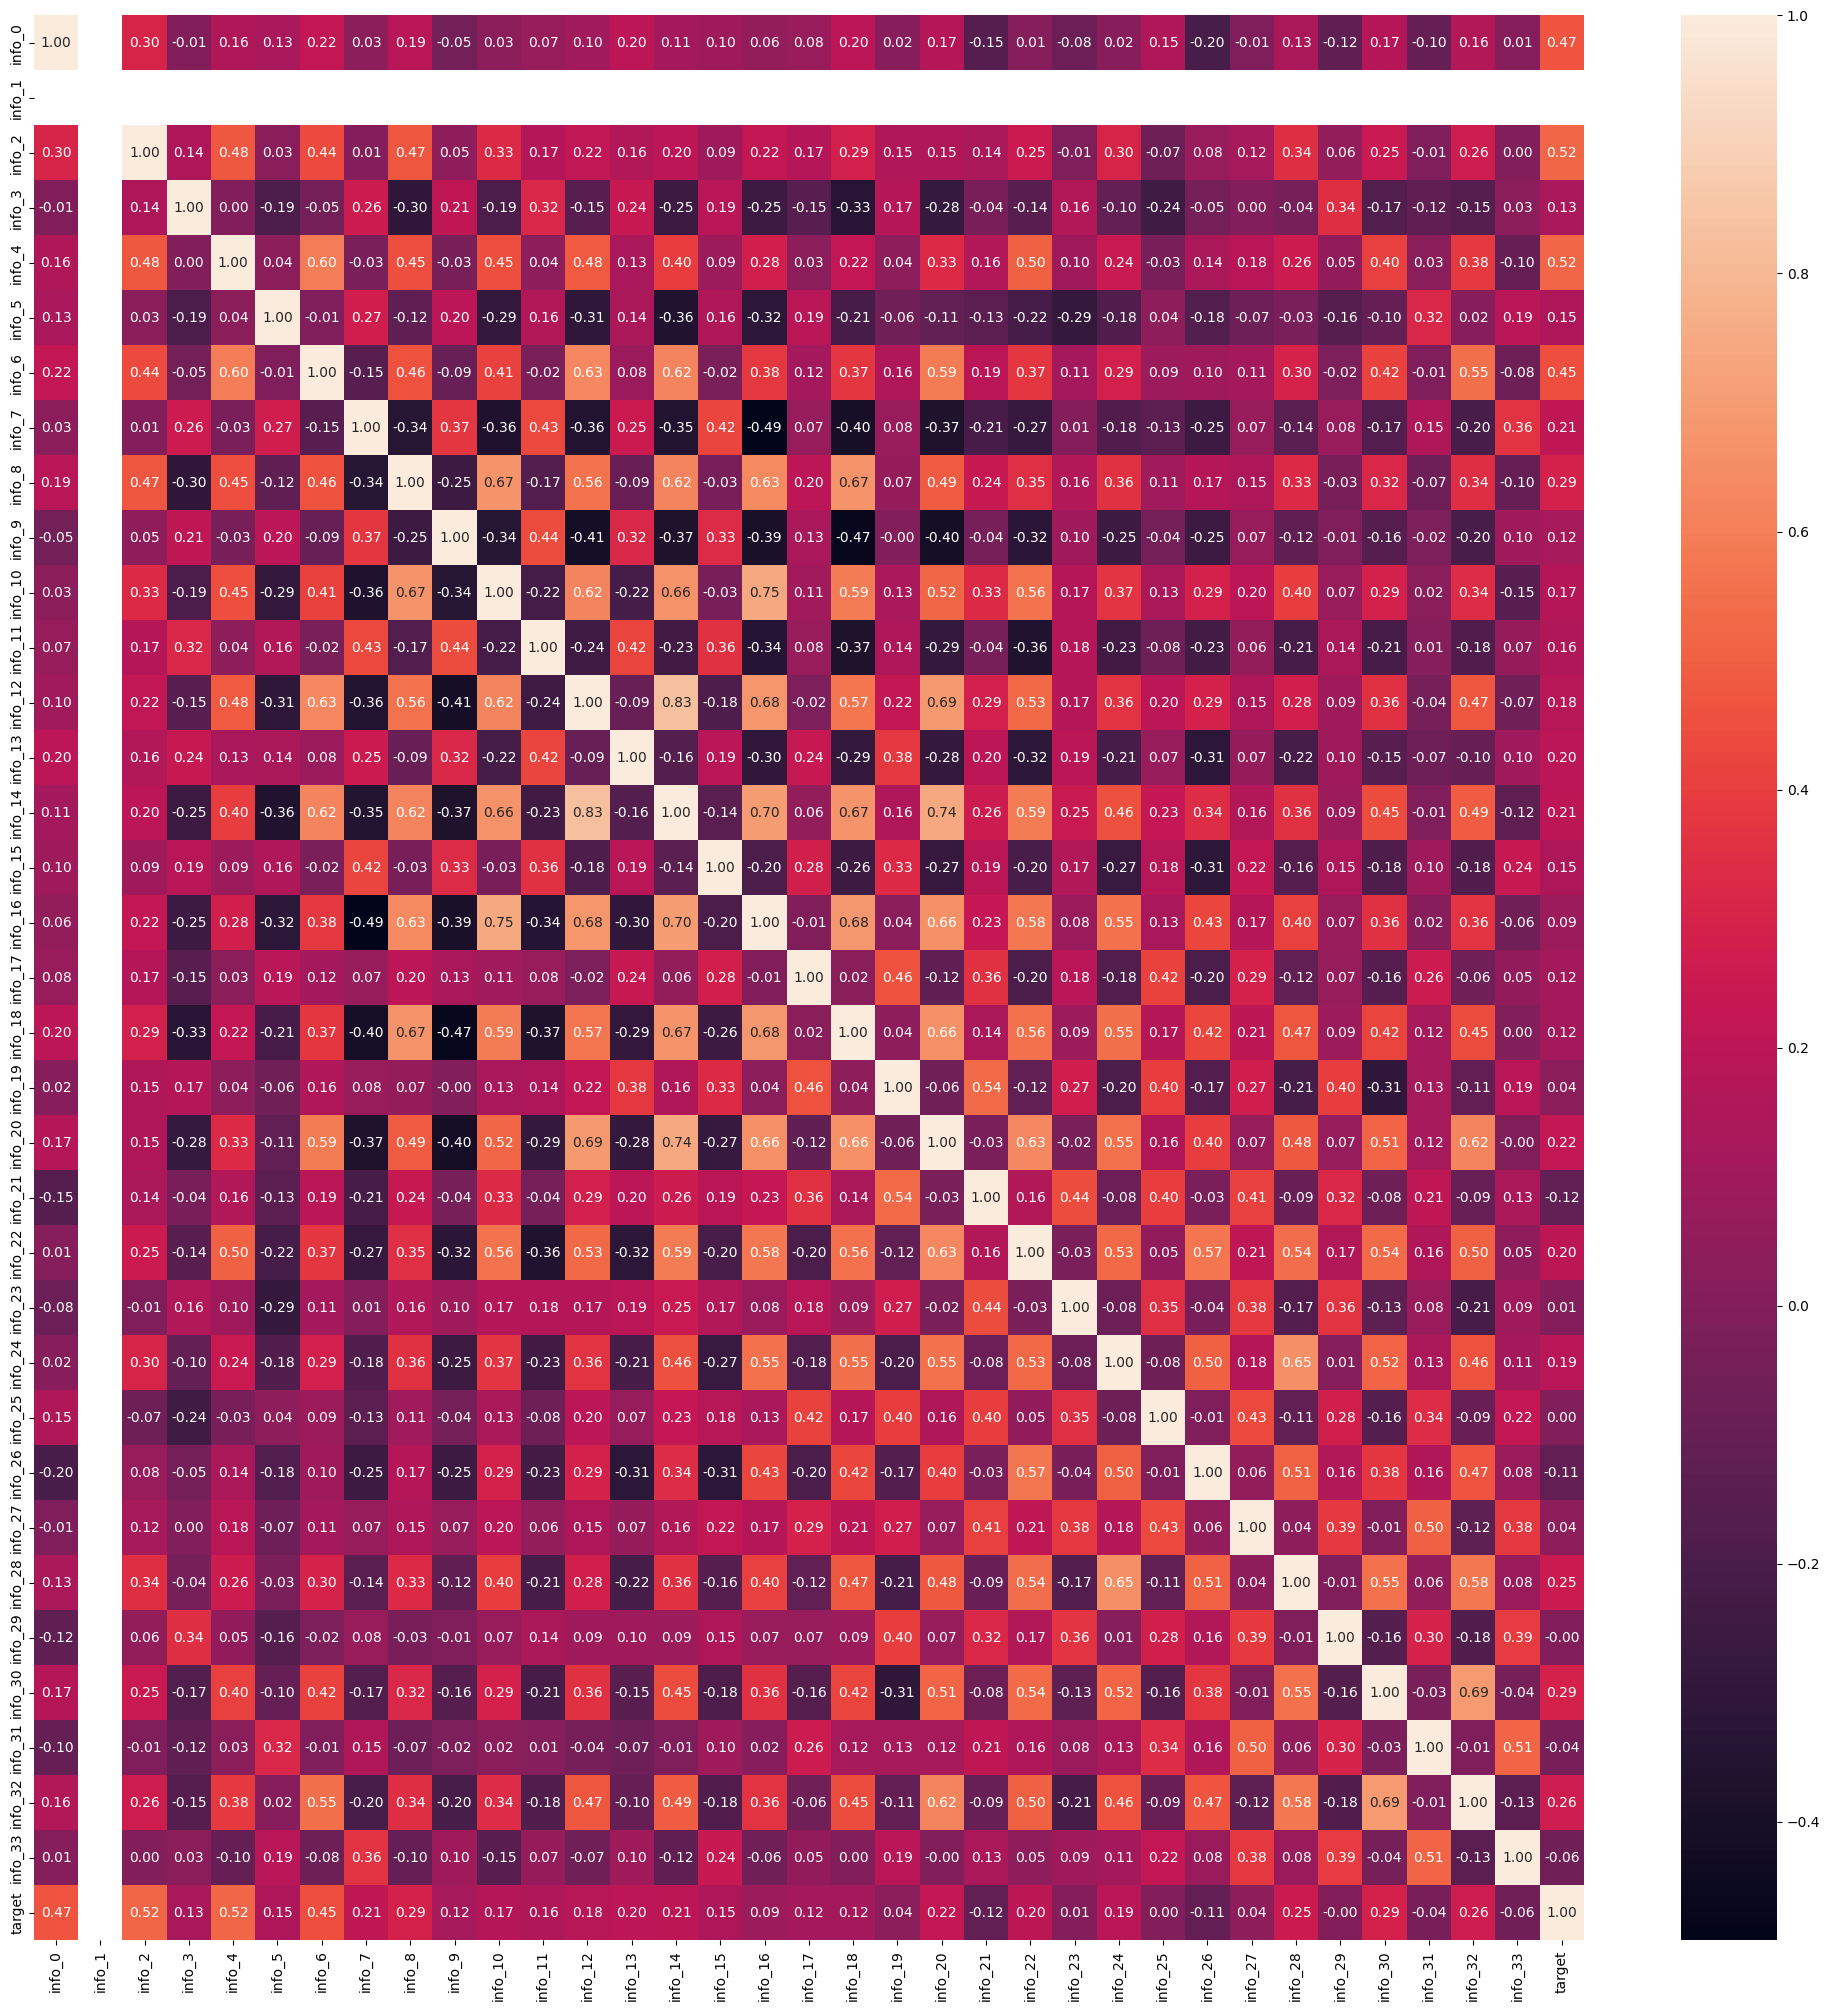

In [12]:
plt.figure(figsize=(25,25))
sns.heatmap(dataset.corr(), annot=True, fmt="0.2f");

#### Resposta

O dataset tem 35 variáveis: as duas primeias variáveis são inteiras (info_1 e info_2), as seguintes até à variável 34 são do tipo float correspondente, 
as sinais de radiofrequência recebidos, e o atributi 'target' é do tipo object, na qual descrebe a presença de elétronc livres na ionosfera ('g' ou 'b').
Deste modo, ao analisar de correlação de varaveis foi eliminada o atributo 'info_1' do dataset para que não influencie de maneira negativa o modelo.

Existe uma alta correlação entre os distintos atributos, por exemplo: 'info 10' e 'info_8' analisando o heatmap do rascunho, 'info_14' e 'info_12' é igual a 0,83. Aliás, existe coleniealidade entre as variáveis por tanto, seria uma boa opção redução de dimensionalidade é capaz de simplificar modelos, reduzir o tempo de treino.

In [13]:
dataset= dataset.drop(['info_1'], axis=1)

<AxesSubplot: xlabel='target', ylabel='count'>

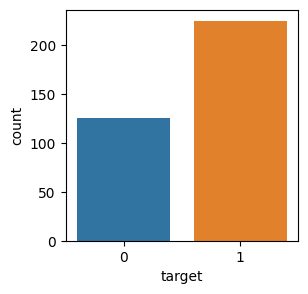

In [14]:
plt.figure(figsize=(3,3))
sns.countplot(data= dataset, x='target')

### 2)	Implemente técnicas de visualização de dados e seleção de variáveis para extrair características importantes sobre a base de dados. Explique a motivação destas técnicas e o que é possível inferir dos resultados obtidos.

#### Rascunho

<AxesSubplot: >

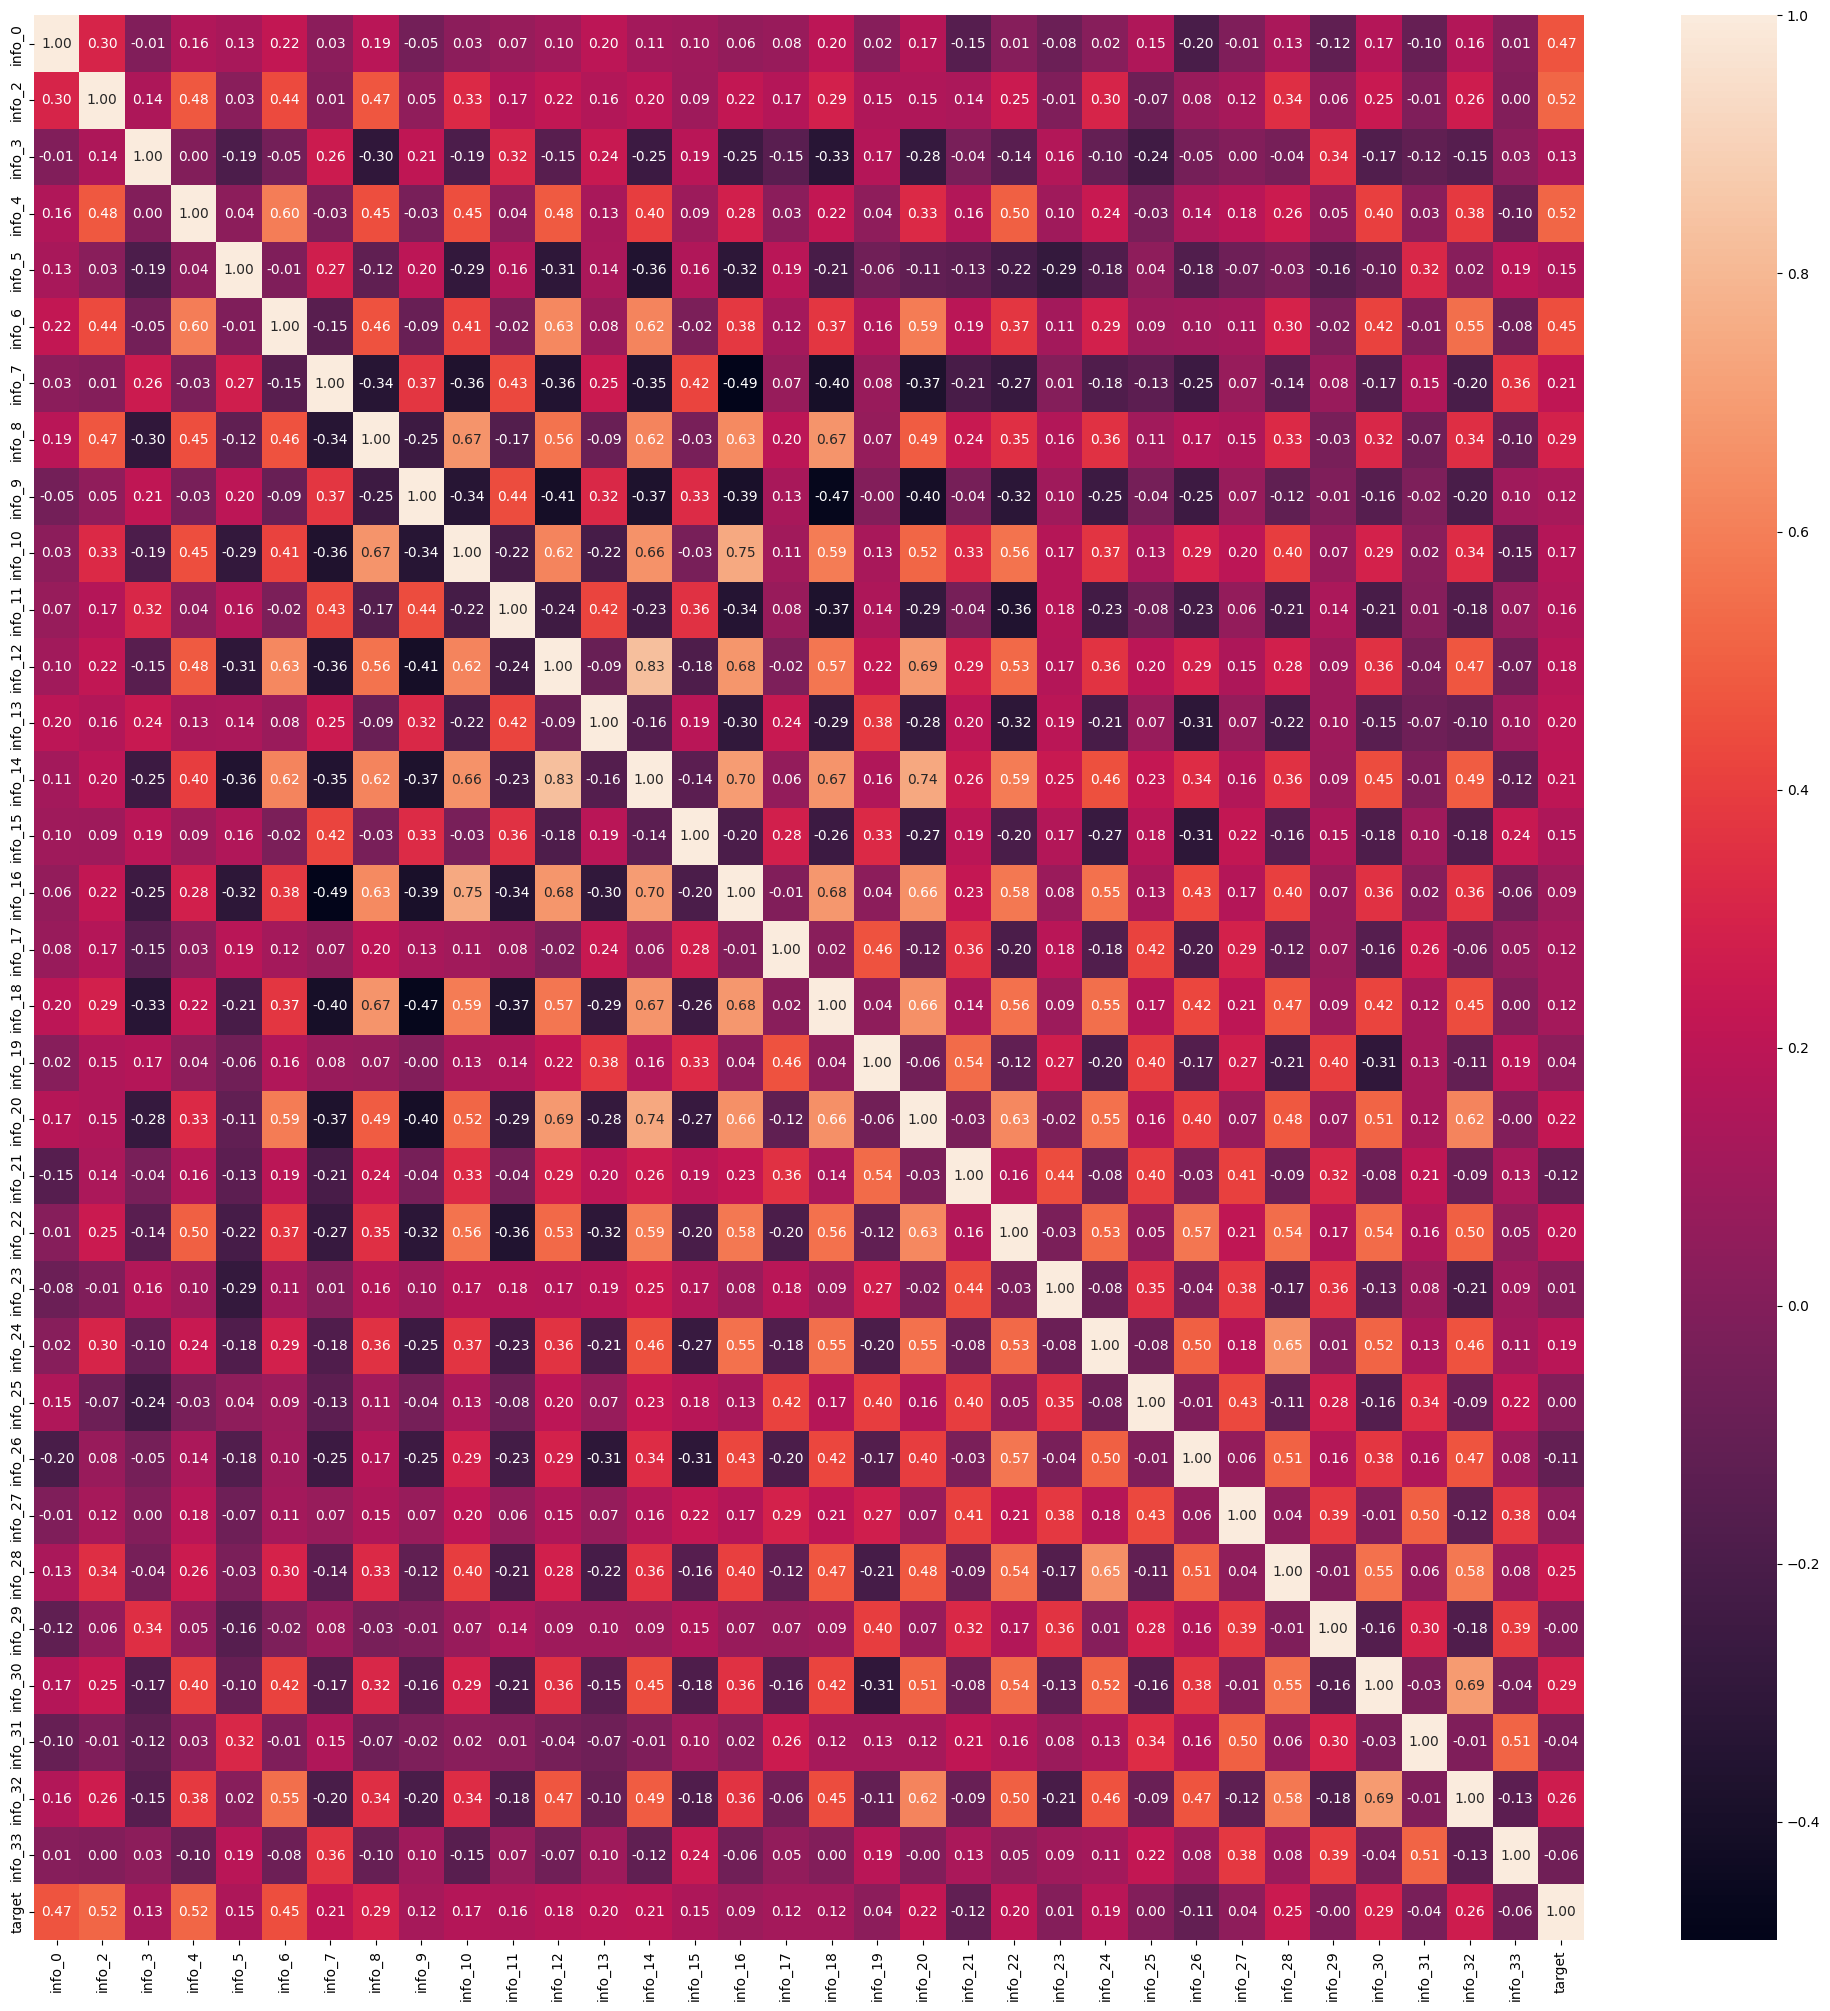

In [15]:
plt.figure(figsize=(25,25))
sns.heatmap(dataset.corr(), annot=True, fmt="0.2f")

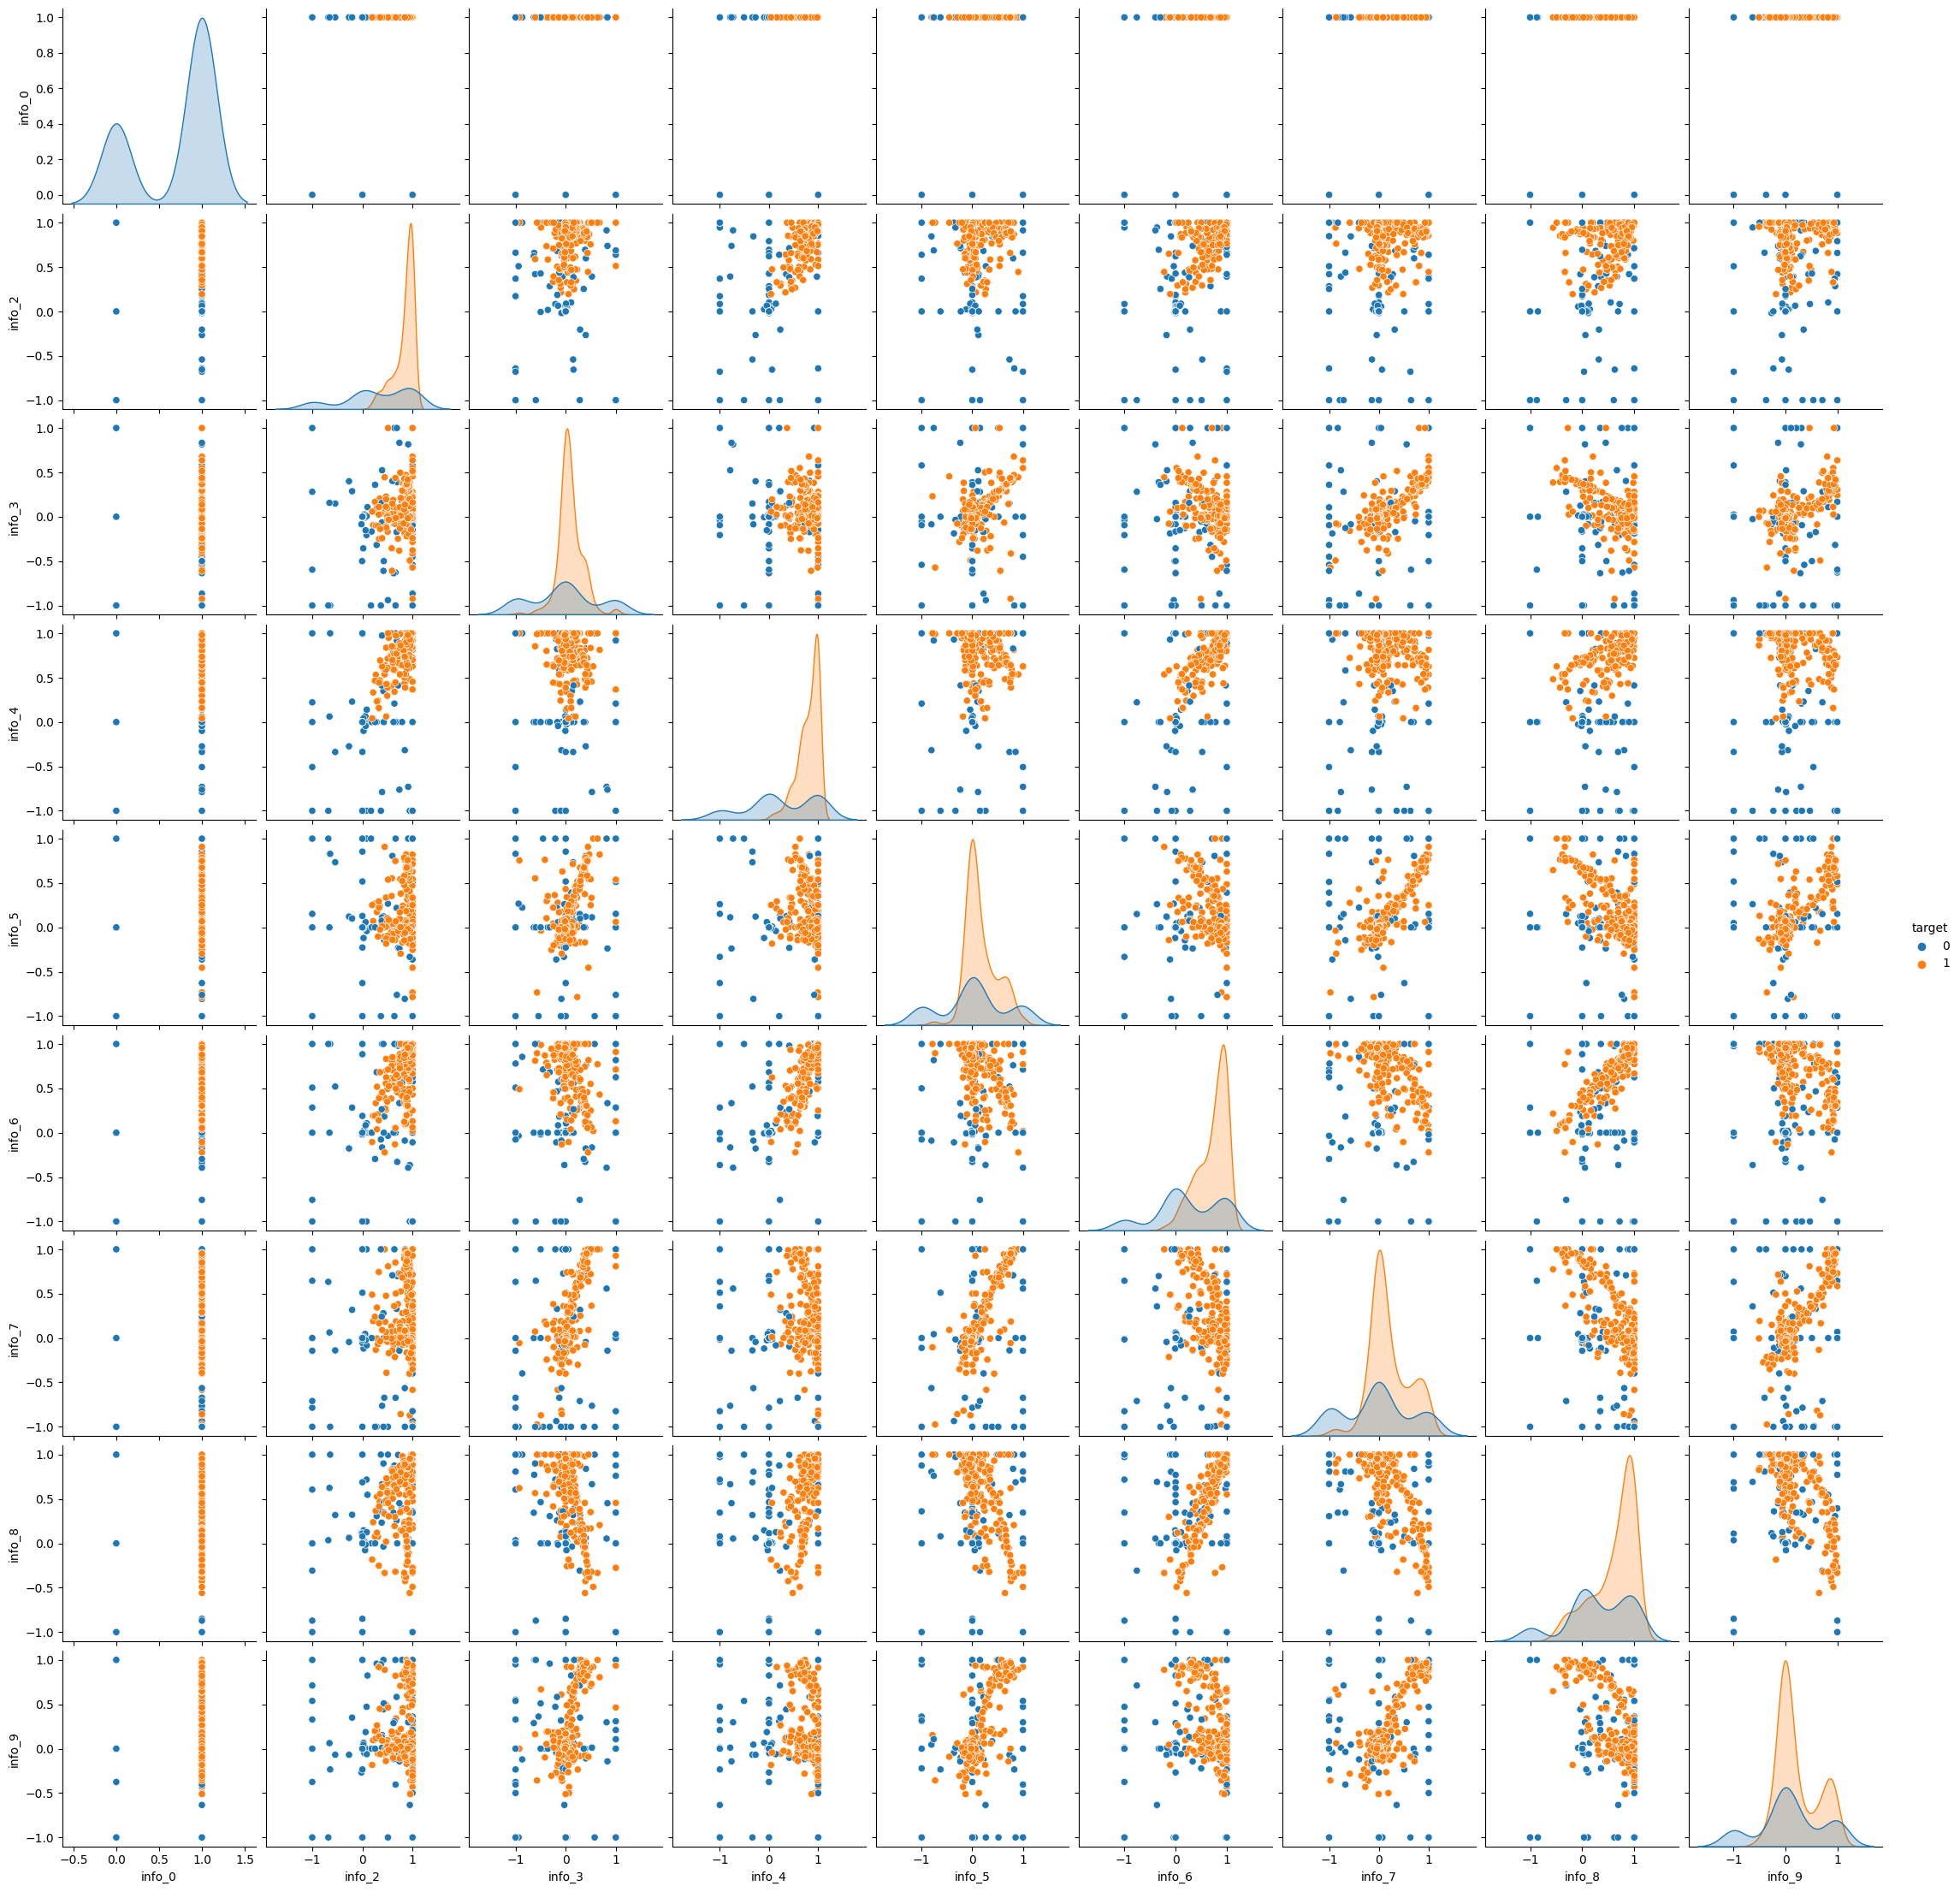

In [16]:
sns.pairplot(dataset, vars=['info_0', 'info_2', 'info_3', 'info_4', 'info_5', 'info_6', 'info_7', 'info_8', 'info_9'], hue='target')
plt.show()

#### Resposta

- As técnicas geométricas permitem a visualização dos dados através de transformações geométricas (ex. reorganizações, projeções) dos valores dos atributos.
Uma das técnicas geométricas mais conhecidas é o pairplot, que coloca vários gráficos de dispersão em um gráfico e também fornece a distribuição na diagonal.
O gráfico inclui duas variáveis ​​para este gráfico padrão. Obteremos todos os gráficos no gráfico de pares segregados pela variável 'target'.

    Mas neste caso ao ter 34 variáveis, o gráfico de pairplot não é muito útil, por tanto, foi utilizado o heatmap para analisar a correlação entre as variáveis. Porém, foi graficado o pairplot para analisar a distribuição dos dados das 9 variaveis.

- A visualização de dados em gráficos pode ser uma técnica útil para identificar padrões e relacionamentos entre variáveis. Gráficos de dispersão, mapas de calor (heatmap), gráficos de barras e gráficos de linhas podem ser usados para visualizar relações entre variáveis e identificar possíveis correlações.

- Analizando o heatmap geradoe xiste uma alta correlação entre os distintos atributos, por exemplo: 'info 10' e 'info_8' analisando o heatmap do rascunho, 'info_14' e 'info_12' é igual a 0,83. Aliás, existe coleniealidade entre as variáveis por tanto, seria uma boa opção redução de dimensionalidade é capaz de simplificar modelos, reduzir o tempo de treino.

No entanto, é importante lembrar que as técnicas geométricas e de visualização de dados são ferramentas exploratórias e não substituem a análise estatística rigorosa. É importante avaliar cuidadosamente a significância estatística das associações entre variáveis e evitar inferências incorretas ou enganosas com base em visualizações de dados.

## Parte II. Treinamento do modelo de Rede Neural - Baseline 

Total: 1,0 pts.

### 1)	Com as configurações do modelo MLP previamente definidas no script, faça o treinamento da Rede Neural sem normalizar os atributos numéricos. Comente o resultado obtido, baseado nas métricas de avaliação disponíveis (acurácia, precision, recall, F1-Score, Matriz de confusão, etc.)

#### Rascunho

In [17]:
np.random.seed(42)
torch.manual_seed(0)

In [18]:
new_df = transform_data(dataset, normalize=False)

In [19]:
new_df.head()

info_0   info_2   info_3   info_4   info_5   info_6   info_7   info_8  \
0       1  0.99539 -0.05889  0.85243  0.02306  0.83398 -0.37708  1.00000   
1       1  1.00000 -0.18829  0.93035 -0.36156 -0.10868 -0.93597  1.00000   
2       1  1.00000 -0.03365  1.00000  0.00485  1.00000 -0.12062  0.88965   
3       1  1.00000 -0.45161  1.00000  1.00000  0.71216 -1.00000  0.00000   
4       1  1.00000 -0.02401  0.94140  0.06531  0.92106 -0.23255  0.77152   

    info_9  info_10  ...  info_25  info_26  info_27  info_28  info_29  \
0  0.03760  0.85243  ... -0.51171  0.41078 -0.46168  0.21266 -0.34090   
1 -0.04549  0.50874  ... -0.26569 -0.20468 -0.18401 -0.19040 -0.11593   
2  0.01198  0.73082  ... -0.40220  0.58984 -0.22145  0.43100 -0.17365   
3  0.00000  0.00000  ...  0.90695  0.51613  1.00000  1.00000 -0.20099   
4 -0.16399  0.52798  ... -0.65158  0.13290 -0.53206  0.02431 -0.62197   

   info_30  info_31  info_32  info_33  target  
0  0.42267 -0.54487  0.18641 -0.45300       1  
1 -0.16626 -0.06288 -0.13738 -0.02447       0  
2  0.60436 -0.24180  0.56045 -0.38238       1  
3  0.25682  1.00000 -0.32382  1.00000       0  
4 -0.05707 -0.59573 -0.04608 -0.65697       1  

[5 rows x 34 columns]

In [20]:
X = new_df.values[:,:-1].astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)

n_input = X.shape[1]

if np.unique(y).shape[0] <= 2:
  print('Binary classification')
  n_output = 1
  binary = True
else:
  print('Multiclass classification')
  n_output = len(encoder.classes_)
  binary = False
  #y = np.eye(n_output)[y]

Binary classification


In [21]:
batch_size = 32 
epochs = 170

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)

In [55]:

#Para o caso de múltiplas classes
#train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
#val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
#test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())



In [23]:
#Para o caso binário
if binary:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
else:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [24]:
train_dataset.X_data

tensor([[ 1.0000, -0.6562,  0.1562,  ...,  0.0000,  0.0000,  0.0938],
        [ 1.0000,  0.9902, -0.0578,  ..., -0.8028,  0.4920, -0.8324],
        [ 1.0000,  0.8703,  0.4697,  ...,  0.5657, -0.0674,  0.5755],
        ...,
        [ 1.0000,  0.9818,  0.0000,  ...,  0.1646,  0.5884,  0.1708],
        [ 0.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
        [ 1.0000,  0.9225, -0.1945,  ..., -0.5407, -0.0746, -0.4790]])

In [25]:
# Normalização dos dados - checar se é necessário
torch.min(train_dataset.X_data),torch.max(train_dataset.X_data) 

(tensor(-1.), tensor(1.))

In [26]:
model = NeuralNetwork(n_input = n_input, n_output=n_output,output_activation='sigmoid')

In [28]:
lr = 0.01
epochs = 250

history, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary, skip=epochs)

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 250: | Train Loss: 0.195 | Val Loss: 0.3111 | Train Acc: 94.0000| Val Acc: 89.0000


In [29]:
y_pred = model.predict(test_dataset.X_data, binary=binary)

#### Resposta

Baseado nas métricas de avaliação disponíveis na matriz de confusão, podemos inferir quantas vezes o modelo fez previsões certas (16 -43) e erradas (0-12), e calcular a acurácia (85%). 
Para o caso de o target 'g'=1 tem uma alta 'precision' e alto 'recall': modelo manipula perfeitamente essa classe. Este é um bom modelo de classificação.
Para o caso de o target 'b'=0 tem alta 'precision e 'recall' medio: o modelo não detecta muito bem a classe "perseguida", mas quando o faz é altamente confiável. F1-Score é o meio harmónico de precision e recall, pelo que não se pode obter um F1 alto se qualquer um deles for muito baixo.

Além disso, devido que as classes estão desbalanceadas (b = 126; g = 225) apresentasse que o modelo leva a treinar melhor o g'=1 que tem 64% dos dados do dataset.

              precision    recall  f1-score   support

           0       1.00      0.61      0.76        28
           1       0.80      1.00      0.89        43

    accuracy                           0.85        71
   macro avg       0.90      0.80      0.82        71
weighted avg       0.88      0.85      0.83        71



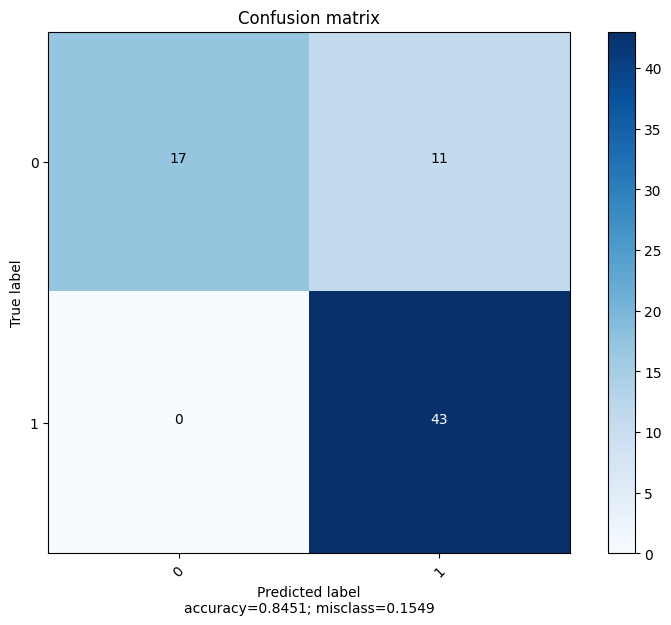

In [30]:
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

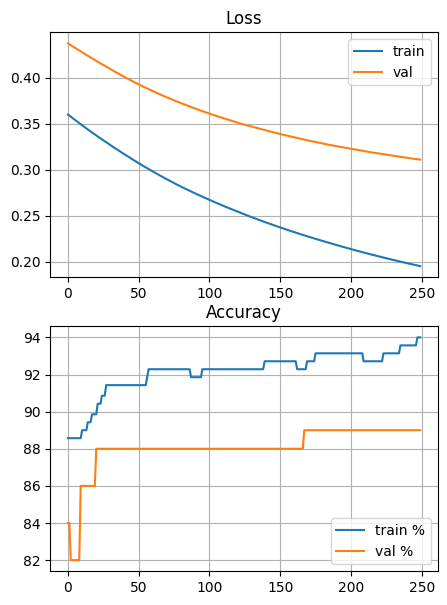

In [31]:
from utils import plot_loss_acc
plot_loss_acc(history)

## Parte III - Mudança de configurações do modelo

Total: 5,0 pts.

### 1)	Agora normalize os dados de entrada e treine novamente o modelo MLP. Avalie os resultados obtidos e comente o efeito da normalização no treinamento da Rede Neural.

#### Rascunho

In [32]:
new_df = transform_data(dataset, normalize=True)
new_df.head()

info_0    info_2    info_3    info_4    info_5   info_6    info_7  \
0     1.0  0.997695  0.470555  0.926215  0.511530  0.91699  0.311460   
1     1.0  1.000000  0.405855  0.965175  0.319220  0.44566  0.032015   
2     1.0  1.000000  0.483175  1.000000  0.502425  1.00000  0.439690   
3     1.0  1.000000  0.274195  1.000000  1.000000  0.85608  0.000000   
4     1.0  1.000000  0.487995  0.970700  0.532655  0.96053  0.383725   

     info_8    info_9   info_10  ...   info_25   info_26   info_27   info_28  \
0  1.000000  0.518800  0.926215  ...  0.244145  0.705390  0.269160  0.606330   
1  1.000000  0.477255  0.754370  ...  0.367155  0.397660  0.407995  0.404800   
2  0.944825  0.505990  0.865410  ...  0.298900  0.794920  0.389275  0.715500   
3  0.500000  0.500000  0.500000  ...  0.953475  0.758065  1.000000  1.000000   
4  0.885760  0.418005  0.763990  ...  0.174210  0.566450  0.233970  0.512155   

    info_29   info_30   info_31   info_32   info_33  target  
0  0.329550  0.711335  0.227565  0.593205  0.273500       1  
1  0.442035  0.416870  0.468560  0.431310  0.487765       0  
2  0.413175  0.802180  0.379100  0.780225  0.308810       1  
3  0.399505  0.628410  1.000000  0.338090  1.000000       0  
4  0.189015  0.471465  0.202135  0.476960  0.171515       1  

[5 rows x 34 columns]

In [33]:
X = new_df.values[:,:-1].astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)

n_input = X.shape[1]

if np.unique(y).shape[0] <= 2:
  print('Binary classification')
  n_output = 1

else:
  print('Multiclass classification')
  #y = to_categorical(y)
  n_output = encoder.classes_.shape[0]


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)

Binary classification


In [34]:
if binary:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
else:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [35]:
# Normalização dos dados - checar se é necessário
torch.min(train_dataset.X_data),torch.max(train_dataset.X_data) 

(tensor(0.), tensor(1.))

In [36]:
model = NeuralNetwork(n_input = n_input, n_output=n_output,output_activation='sigmoid')
history, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary, skip=epochs)

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 250: | Train Loss: 0.449 | Val Loss: 0.4731 | Train Acc: 79.1429| Val Acc: 77.0000


In [37]:
y_pred = model.predict(test_dataset.X_data,binary=binary)


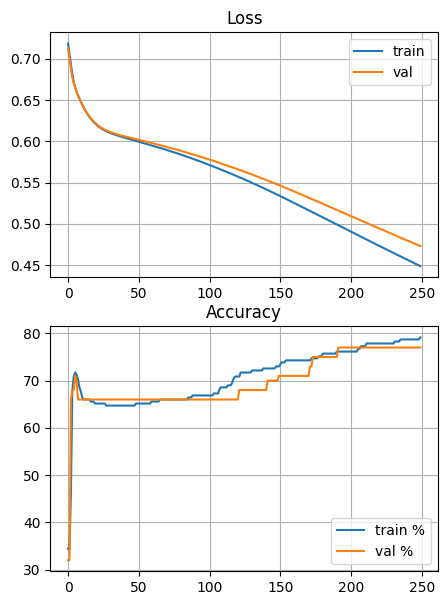

In [38]:
plot_loss_acc(history)

#### Resposta

Devido a que os dados originais obtidos do dataset se encontram estandarizados numa faixa de -1 até 1, e se apresentava uma accuracia do 85%, adicionalmente o recall para o target 'b'=0.57 e para o target 'g'=1.00 o número dos dados que foram classficados foi 43.

Além do que neste caso, ao normalizar os dados numa faixa de 0 até 1, se apresenta uma acurácia = 68%, isto gera que ao aplicar uma nova normalização sobre os dados o modelo disminue o desempenho num 15%, ou seja, disminue a sua capacidade de classificar o target.

Também observase a capacidade do modelo ao clasificar o target '0', de ter recall=0,57 de 28 dados, ao ter  recall=0,18.

Os resultados na visualização do 'history' respeito ao treinamento sem normalização pode-se inferir que o modelo leva a treinar melhor o target 'g'= 1, tendo um valor de 'precision'=0,65 e 'recall'=1,0.

              precision    recall  f1-score   support

           0       1.00      0.32      0.49        28
           1       0.69      1.00      0.82        43

    accuracy                           0.73        71
   macro avg       0.85      0.66      0.65        71
weighted avg       0.81      0.73      0.69        71



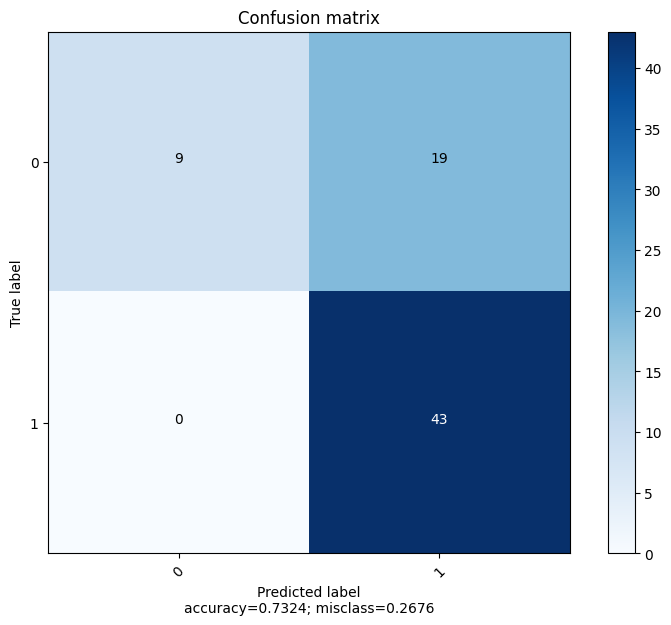

In [39]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

### 2)	Modifique o tempo de treinamento (épocas) da Rede Neural. Escolha valores distintos (e.g. 1 e 1000 épocas) e avalie os resultados.

#### Rascunho (treinamento com 900 épocas)

In [40]:
np.random.seed(42)
torch.manual_seed(0)

In [41]:
new_df = transform_data(dataset, normalize=False)
new_df.head()

info_0   info_2   info_3   info_4   info_5   info_6   info_7   info_8  \
0       1  0.99539 -0.05889  0.85243  0.02306  0.83398 -0.37708  1.00000   
1       1  1.00000 -0.18829  0.93035 -0.36156 -0.10868 -0.93597  1.00000   
2       1  1.00000 -0.03365  1.00000  0.00485  1.00000 -0.12062  0.88965   
3       1  1.00000 -0.45161  1.00000  1.00000  0.71216 -1.00000  0.00000   
4       1  1.00000 -0.02401  0.94140  0.06531  0.92106 -0.23255  0.77152   

    info_9  info_10  ...  info_25  info_26  info_27  info_28  info_29  \
0  0.03760  0.85243  ... -0.51171  0.41078 -0.46168  0.21266 -0.34090   
1 -0.04549  0.50874  ... -0.26569 -0.20468 -0.18401 -0.19040 -0.11593   
2  0.01198  0.73082  ... -0.40220  0.58984 -0.22145  0.43100 -0.17365   
3  0.00000  0.00000  ...  0.90695  0.51613  1.00000  1.00000 -0.20099   
4 -0.16399  0.52798  ... -0.65158  0.13290 -0.53206  0.02431 -0.62197   

   info_30  info_31  info_32  info_33  target  
0  0.42267 -0.54487  0.18641 -0.45300       1  
1 -0.16626 -0.06288 -0.13738 -0.02447       0  
2  0.60436 -0.24180  0.56045 -0.38238       1  
3  0.25682  1.00000 -0.32382  1.00000       0  
4 -0.05707 -0.59573 -0.04608 -0.65697       1  

[5 rows x 34 columns]

In [42]:
X = new_df.values[:,:-1].astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)

n_input = X.shape[1]

if np.unique(y).shape[0] <= 2:
  print('Binary classification')
  n_output = 1

else:
  print('Multiclass classification')
  #y = to_categorical(y)
  n_output = encoder.classes_.shape[0]


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)

Binary classification


In [43]:
if binary:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
else:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [44]:
lr = 0.01
epochs = 900
model = NeuralNetwork(n_input = n_input, n_output=n_output,output_activation='sigmoid')
history, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary, skip=epochs)

  0%|          | 0/900 [00:00<?, ?it/s]

Epoch 900: | Train Loss: 0.123 | Val Loss: 0.2735 | Train Acc: 96.1429| Val Acc: 91.0000


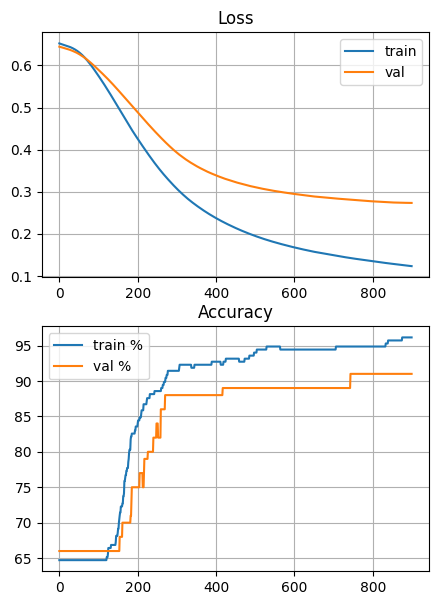

In [45]:
plot_loss_acc(history)

              precision    recall  f1-score   support

           0       1.00      0.64      0.78        28
           1       0.81      1.00      0.90        43

    accuracy                           0.86        71
   macro avg       0.91      0.82      0.84        71
weighted avg       0.89      0.86      0.85        71



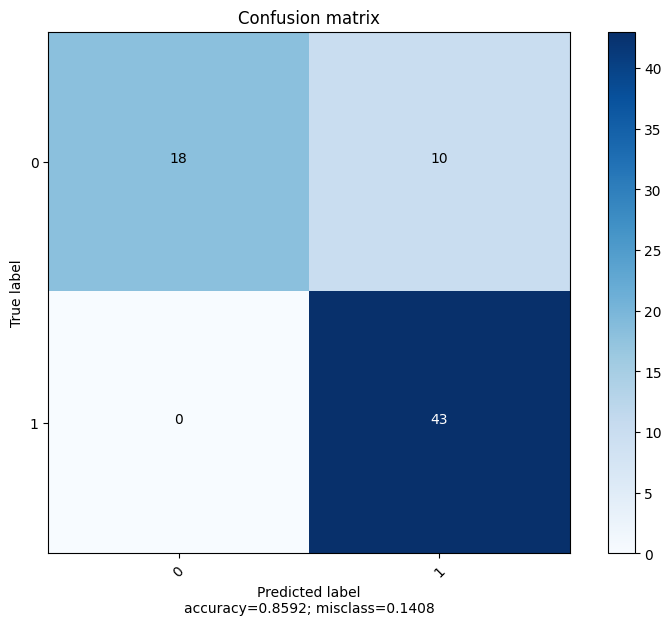

In [46]:
y_pred = model.predict(test_dataset.X_data, binary=binary)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

#### Resposta (Treiamento com 900 épocas)

Se uma rede neural é treinada por muitas épocas, ela pode começar a memorizar os dados de treinamento em vez de aprender os padrões subjacentes que permitem que a rede faça previsões precisas sobre novos dados. Esse fenômeno é chamado de sobreajuste (overfitting).

O modelo apresenta uma acurácia de 86% e um recall de 0,64 para o target 'b'=0, e um recall de 1,0 para o target 'g'=1.0. Isto quer dizer que o modelo é capaz de classificar melhor o target 'g'=1, mas não o target 'b'=0.

#### Rascunho (treinamento com 2 épocas)

In [48]:
new_df = transform_data(dataset, normalize=False)
new_df.head()

info_0   info_2   info_3   info_4   info_5   info_6   info_7   info_8  \
0       1  0.99539 -0.05889  0.85243  0.02306  0.83398 -0.37708  1.00000   
1       1  1.00000 -0.18829  0.93035 -0.36156 -0.10868 -0.93597  1.00000   
2       1  1.00000 -0.03365  1.00000  0.00485  1.00000 -0.12062  0.88965   
3       1  1.00000 -0.45161  1.00000  1.00000  0.71216 -1.00000  0.00000   
4       1  1.00000 -0.02401  0.94140  0.06531  0.92106 -0.23255  0.77152   

    info_9  info_10  ...  info_25  info_26  info_27  info_28  info_29  \
0  0.03760  0.85243  ... -0.51171  0.41078 -0.46168  0.21266 -0.34090   
1 -0.04549  0.50874  ... -0.26569 -0.20468 -0.18401 -0.19040 -0.11593   
2  0.01198  0.73082  ... -0.40220  0.58984 -0.22145  0.43100 -0.17365   
3  0.00000  0.00000  ...  0.90695  0.51613  1.00000  1.00000 -0.20099   
4 -0.16399  0.52798  ... -0.65158  0.13290 -0.53206  0.02431 -0.62197   

   info_30  info_31  info_32  info_33  target  
0  0.42267 -0.54487  0.18641 -0.45300       1  
1 -0.16626 -0.06288 -0.13738 -0.02447       0  
2  0.60436 -0.24180  0.56045 -0.38238       1  
3  0.25682  1.00000 -0.32382  1.00000       0  
4 -0.05707 -0.59573 -0.04608 -0.65697       1  

[5 rows x 34 columns]

In [49]:
X = new_df.values[:,:-1].astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)

n_input = X.shape[1]

if np.unique(y).shape[0] <= 2:
  print('Binary classification')
  n_output = 1

else:
  print('Multiclass classification')
  #y = to_categorical(y)
  n_output = encoder.classes_.shape[0]


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)

Binary classification


In [50]:
if binary:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
else:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [51]:
lr = 0.01
epochs = 2
model = NeuralNetwork(n_input = n_input, n_output=n_output,output_activation='sigmoid')
history, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary, skip=epochs)

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 002: | Train Loss: 0.760 | Val Loss: 0.7626 | Train Acc: 35.2857| Val Acc: 34.0000


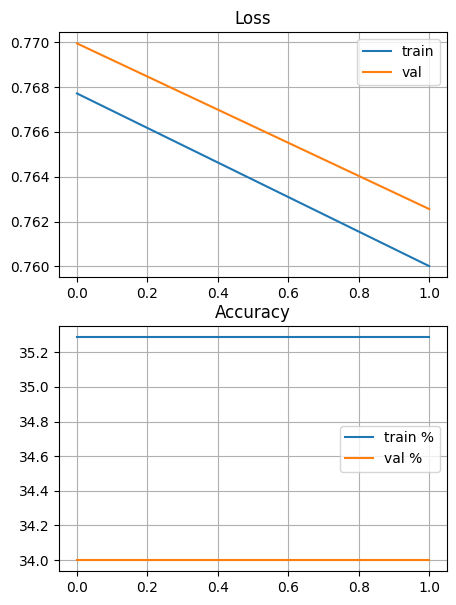

In [52]:
plot_loss_acc(history)

c:\Users\lauri\.conda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lauri\.conda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lauri\.conda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.39      1.00      0.57        28
           1       0.00      0.00      0.00        43

    accuracy                           0.39        71
   macro avg       0.20      0.50      0.28        71
weighted avg       0.16      0.39      0.22        71



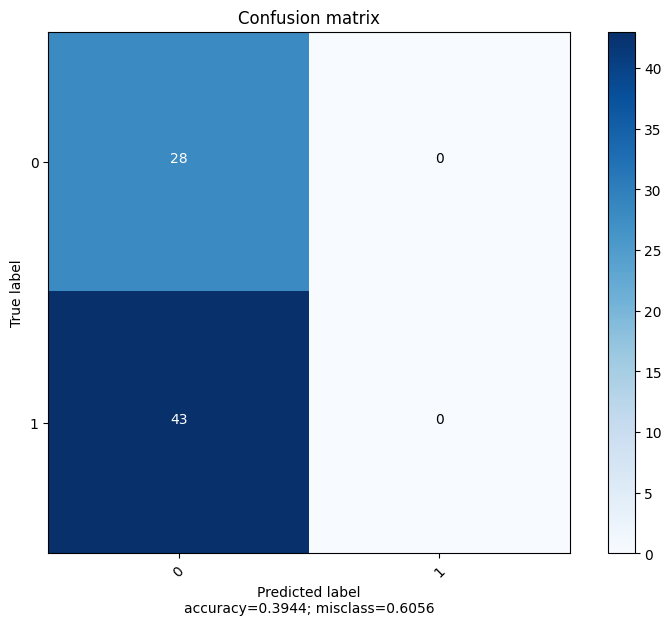

In [53]:
y_pred = model.predict(test_dataset.X_data, binary=binary)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

#### Resposta (treinamento com 2 épocas)

Quando fazemos o treinamento de uma rede neural poucas épocas (neste caso ex: 2 épocas), é possível que ela não consiga aprender todos os padrões importantes presentes nos dados de treinamento. Isso pode levar a uma baixa precisão da rede em prever corretamente os rótulos dos dados de teste, como se apresenta neste caso a  precisão=0.00 para o target 'g'= 1. Em outras palavras, com poucas épocas de treinamento, a rede pode não ter tempo suficiente para ajustar seus pesos e bias de forma apropriada, resultando em um subajuste (underfitting) do modelo.

Alem disso, no grafico das curvas do aprendizado podemos observar o 'underfitting' ao observar as linhas, ou seja, o modelo apresenta um alto erro de treinamento e um alto erro de validação, isto quer dizer que o modelo não é capaz de generalizar os dados de treinamento e nem os dados de validação. O modelo não aprende nada, pois o valor da acurácia é muito baixo, e o valor do recall para o target 'b'=0 é 0,0 e para o target 'g'=1 é 1,0.


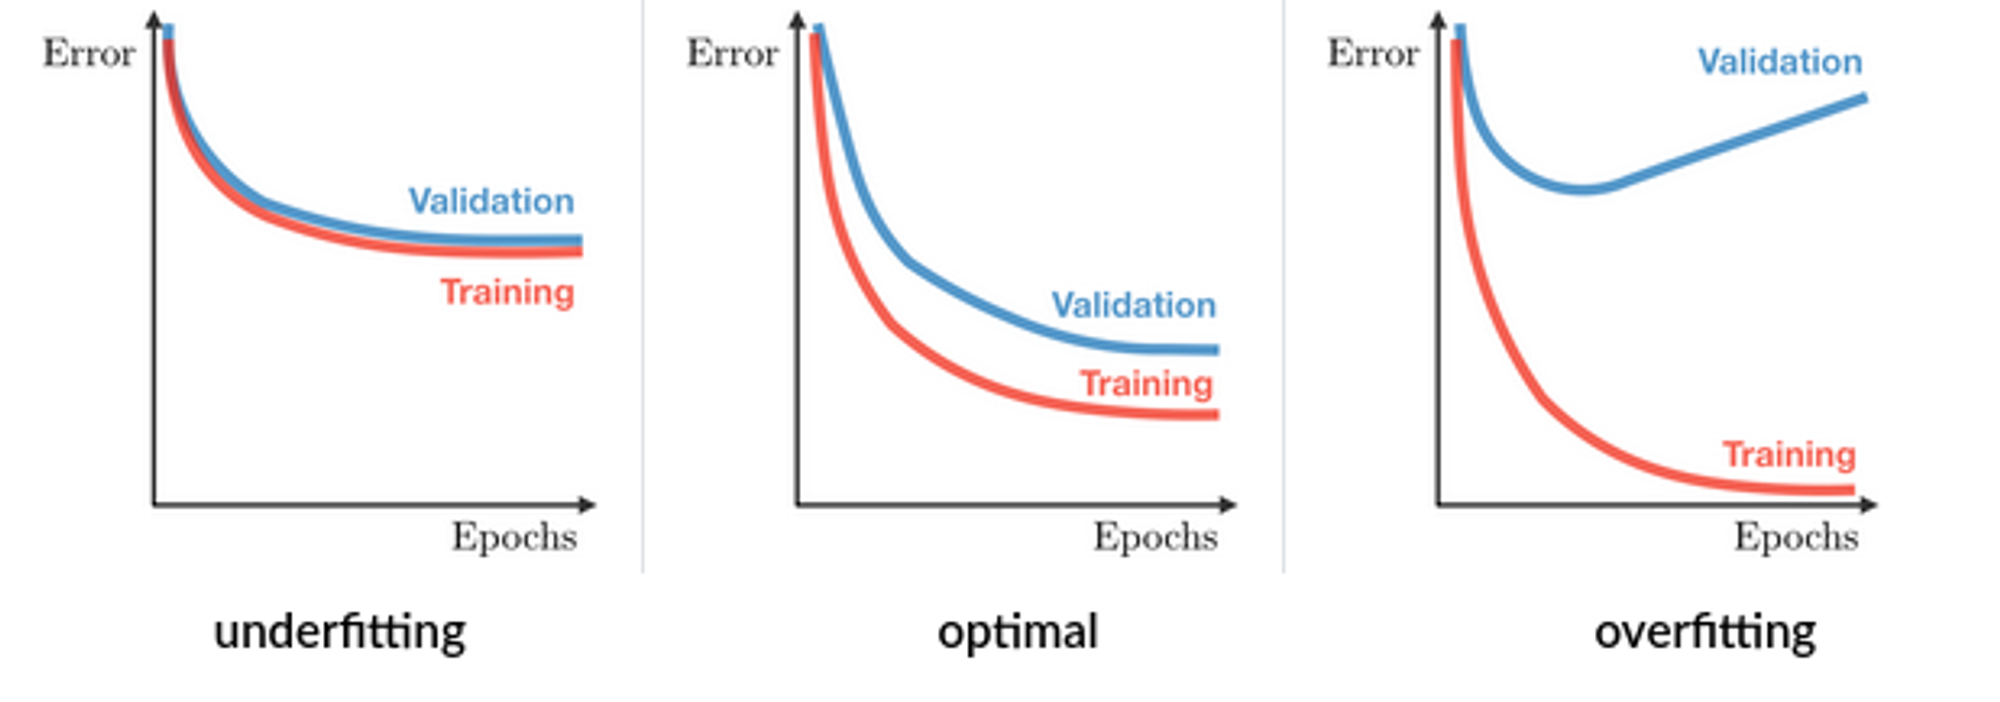


### 3)	 Modifique a taxa de aprendizado da Rede Neural. Escolha valores distintos (e.g. 0,001 e 0,1) e avalie os resultados.

#### Rascunho (taxa de aprendizaso 0.001)

In [57]:
lr = 0.001
epochs = 250
model = NeuralNetwork(n_input = n_input, n_output=n_output,output_activation='sigmoid')
history, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary, skip=epochs)

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 250: | Train Loss: 0.636 | Val Loss: 0.6363 | Train Acc: 67.2857| Val Acc: 70.0000


              precision    recall  f1-score   support

           0       0.52      0.50      0.51        28
           1       0.68      0.70      0.69        43

    accuracy                           0.62        71
   macro avg       0.60      0.60      0.60        71
weighted avg       0.62      0.62      0.62        71



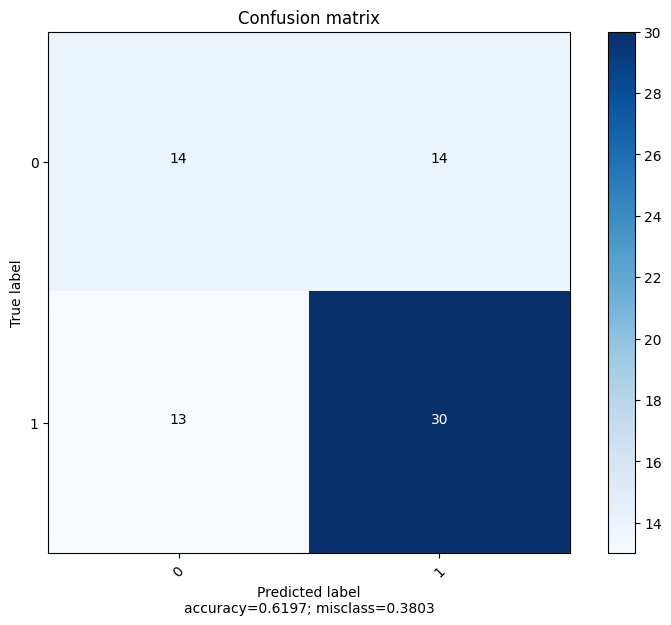

In [58]:
y_pred = model.predict(test_dataset.X_data, binary=binary)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

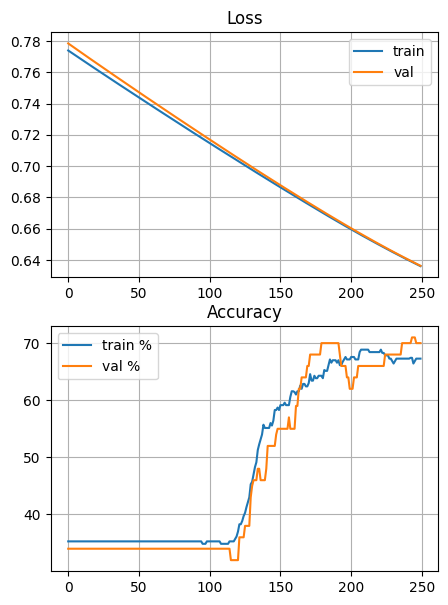

In [59]:
plot_loss_acc(history)

#### Rascunho (taxa de aprendizaso 0.1)

In [60]:
lr = 0.1
epochs = 250
model = NeuralNetwork(n_input = n_input, n_output=n_output,output_activation='sigmoid')
history, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary, skip=epochs)

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 250: | Train Loss: 0.053 | Val Loss: 0.2447 | Train Acc: 99.1429| Val Acc: 91.0000


              precision    recall  f1-score   support

           0       0.95      0.68      0.79        28
           1       0.82      0.98      0.89        43

    accuracy                           0.86        71
   macro avg       0.89      0.83      0.84        71
weighted avg       0.87      0.86      0.85        71



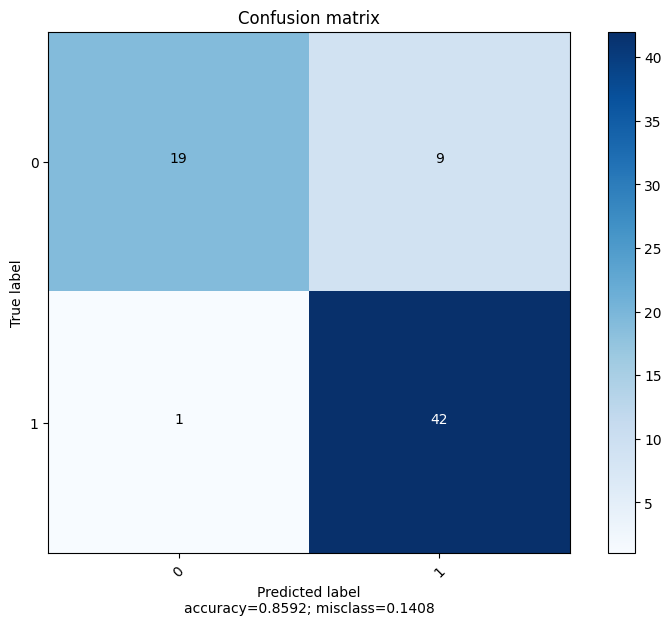

In [61]:
y_pred = model.predict(test_dataset.X_data, binary=binary)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

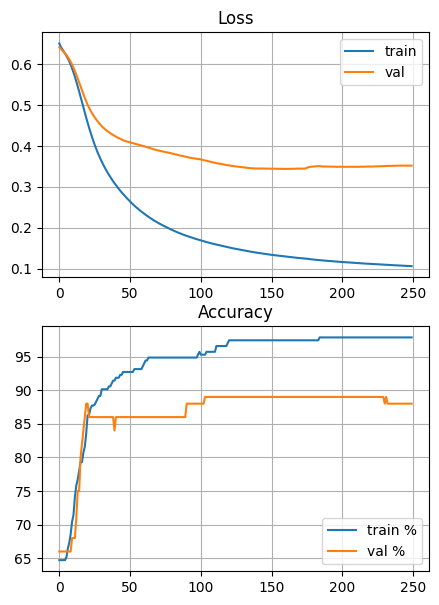

In [56]:
plot_loss_acc(history)

#### Resposta

Podemos perceber que ao ter uma taxa de aprendizado muito baixa torna o aprendizado da rede muito lento, e da pra perceber que requer um número maior de épocas para alcançar a convergencia. Sendo assim, impede a rede neural alcanzar a convergencia. Isso pode acontecer pelo fato que a rede neural precisa de muitas epocas de treinamento para fazer ajustes nos pesos e bias, e assim, conseguir aprender os padrões dos dados de treinamento e dessa maneira fazer previsões precisas.

No caso da taxa de aprendizado muito alta, levando ao overfitting, os pesos da rede podem ser atualizados em grandes incrementos a cada passo do treinamento, o que pode fazer com que a rede "pule" sobre mínimos locais na função de perda e perca a oportunidade de aprender padrões sutis nos dados. Isso pode levar a uma performance pior na validação ou conjunto de teste, mesmo que a performance nos dados de treinamento seja muito boa. O parâmetro taxa de aprendizado tem grande influência durante o processo de treinamento da rede neural.

### 4)	Modifique a quantidade de neurônios na camada escondida da Rede Neural. Escolha valores distintos (e.g. 2 e 70 neurônios) e avalie os resultados.

#### Rascunho

In [63]:
lr = 0.01
epochs = 250
model = NeuralNetwork(hidden_neurons = 2, n_input = n_input, n_output=n_output,output_activation='sigmoid')
history, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary, skip=epochs)

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 250: | Train Loss: 0.342 | Val Loss: 0.4059 | Train Acc: 90.4286| Val Acc: 86.0000


              precision    recall  f1-score   support

           0       1.00      0.54      0.70        28
           1       0.77      1.00      0.87        43

    accuracy                           0.82        71
   macro avg       0.88      0.77      0.78        71
weighted avg       0.86      0.82      0.80        71



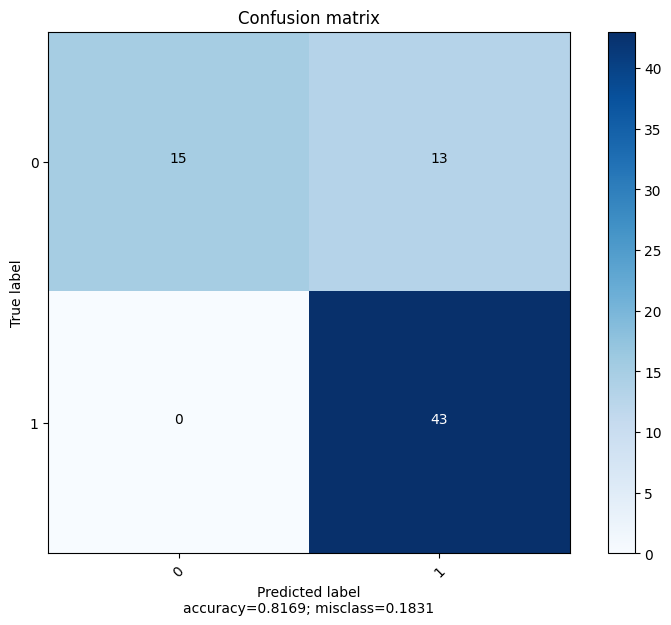

In [64]:
y_pred = model.predict(test_dataset.X_data, binary=binary)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

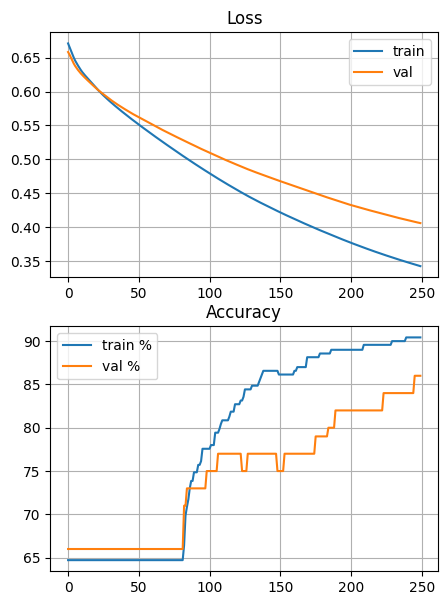

In [65]:
plot_loss_acc(history)

In [66]:
lr = 0.01
epochs = 250
model = NeuralNetwork(hidden_neurons = 70, n_input = n_input, n_output=n_output,output_activation='sigmoid')
history, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary, skip=epochs)

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 250: | Train Loss: 0.210 | Val Loss: 0.3134 | Train Acc: 94.8571| Val Acc: 89.0000


              precision    recall  f1-score   support

           0       1.00      0.68      0.81        28
           1       0.83      1.00      0.91        43

    accuracy                           0.87        71
   macro avg       0.91      0.84      0.86        71
weighted avg       0.90      0.87      0.87        71



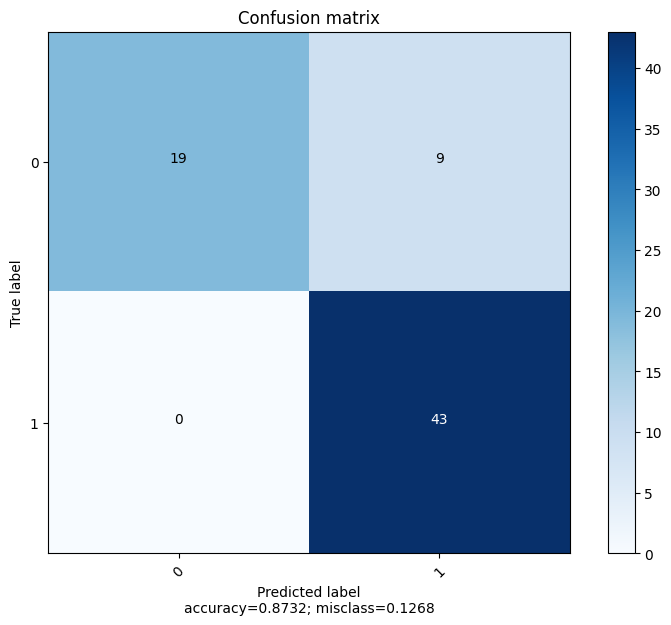

In [67]:
y_pred = model.predict(test_dataset.X_data, binary=binary)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

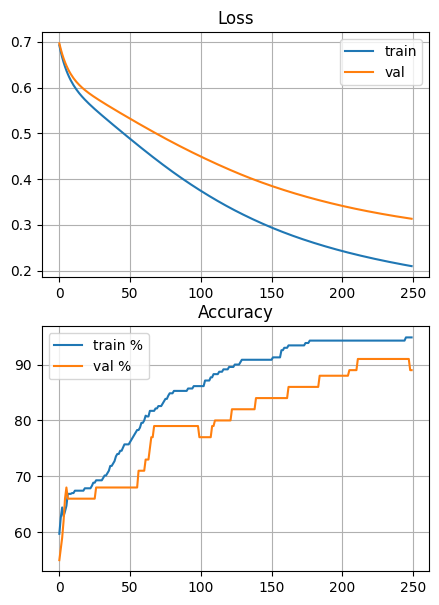

In [68]:
plot_loss_acc(history)

#### Resposta

Com relação ao numero de neurônios nas camadas escondidas, deve-se ter cuidado para não utilizar nem unidades demais, o que pode levar a rede a memorizar os dados de treinamento (overfitting), ao invé s de extrair as características gerais que permitirão a generalização, nem um nú mero muito pequeno, que pode forçar a rede a gastar tempo em excesso tentando encontrar uma representação ótima. Devido a estas dificuldades é recomendado manter o numero de neurônios escondidos baixo, mas não tão baixo quanto o estritamente necessário.

Sendo assim, ao modificar a quantidade de neurônios na camada escondida da Rede Neural, escolhendo valores distintos (e.g. 2 e 70 neurônios) e avaliando os resultados, se apresenta que ao aumentar o numero de neurônios, o modelo tem uma acurácia de 90%, e ao diminuir o numero de neurônios, o modelo tem uma acurácia de 68%.

## Parte IV - Usando outras técnicas para Redes Neurais 
Total: 3,0 pts.

### 1)	Implemente a técnica de parada antecipada (Early Stopping) usando o conjunto de validação. Avalie o resultado obtido.

OBS: para essa questão, copie a função `train` do arquivo `model_utils.py`, copie neste notebook e faça as adaptações necessárias.

#### Rascunho

In [69]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [70]:
import torch.nn as nn
from tqdm.notebook import tqdm
import torch
import numpy as np
from metrics import *
from typing import Tuple, Dict, List

def train_e(model: torch.nn.Module , train_loader: torch.utils.data.DataLoader, 
         val_set: Tuple[torch.Tensor, torch.Tensor], epochs: int, device: torch.device, 
         lr: float, binary: bool = True, skip: int = 1) -> Tuple[Dict[str, List[float]], torch.Tensor]:
    """
    Trains a Pytorch model on a given training data.
    Parameters:
    model (torch.nn.Module): The model to be trained
    train_loader (DataLoader): The training data in the form of a Pytorch DataLoader
    val_set (tuple): A tuple containing the validation data and labels
    epochs (int): The number of times the training data should be passed through the model
    device (str or torch.device): The device on which to perform the computations (e.g. 'cpu' or 'cuda')
    lr (float): The learning rate for the optimizer
    binary (bool): Boolean indicating whether the task is binary classification or not. Default: True
    skip (int): The number of epochs after which the training and validation results will be printed. Default: 1
    Returns:
    tuple: A tuple containing the training history and the predicted labels after training
    """


    if binary:
        criterion = nn.BCEWithLogitsLoss()
    else:
        criterion = nn.CrossEntropyLoss()


    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    history = {'acc_train' : [], 'loss_train': [], 'acc_val': [], 'loss_val': []}
    
    early_stopper = EarlyStopper(patience=2, min_delta=0.01)
    
    for e in tqdm(range(1, epochs+1)):

        y_hat = np.array([])

        train_epoch_loss = 0
        train_epoch_acc = 0
        model.train()
        for X_train_batch, y_train_batch in train_loader:
            X, y = X_train_batch.to(device), y_train_batch.to(device)
            optimizer.zero_grad()
            
            y_pred = model(X)
            
            loss = criterion(y_pred, y)
            if binary:
                acc = binary_acc(y_pred,y)
            else:
                acc = accuracy(y_pred, y)
            
            loss.backward()
            optimizer.step()
            
            train_epoch_loss += loss.item()
            train_epoch_acc += acc.item()
            y_p = torch.argmax(y_pred, dim=1)
            y_hat = np.concatenate((y_hat, y_p))


        model.eval()
        _, val_loss, val_acc = evaluate(model, val_set, criterion, binary=binary)

        history['acc_train'].append(train_epoch_acc/len(train_loader))
        history['loss_train'].append(train_epoch_loss/len(train_loader))
        history['acc_val'].append(val_acc)
        history['loss_val'].append(val_loss)

        if e%skip == 0:
            print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.3f} | Val Loss: {val_loss:.4f} | Train Acc: {train_epoch_acc/len(train_loader):.4f}| Val Acc: {val_acc:.4f}')
        
        if early_stopper.early_stop(val_loss):
            print(f'Early stopping at epoch {e}')          
            break
    
    return history, y_hat

def evaluate(model: torch.nn.Module, val_set: Tuple[torch.tensor, torch.tensor], 
            criterion: torch.nn.Module, binary:bool =True) -> Tuple[torch.tensor, float, float]:
    """
    Evaluates a Pytorch model on a given dataset.
    Parameters:
    model (torch.nn.Module): The model to be evaluated
    data (tuple): A tuple containing the data and labels
    criterion (torch.nn.Module): The loss function to be used
    binary (bool): Boolean indicating whether the task is binary classification or not. Default: True
    Returns:
    tuple: A tuple containing predicted labels, loss, and accuracy
    """
    
    X = val_set.X_data
    y = val_set.y_data
    
    with torch.no_grad():
        y_pred = model(X)
    loss = criterion(y_pred, y)
    if binary:
        acc = binary_acc(y_pred, y)
    else:
        acc = accuracy(y_pred, y)
    y_pred = torch.argmax(y_pred, dim=1)

    return y_pred, loss.item(), acc.item()

In [84]:
lr = 0.08
epochs = 250
model = NeuralNetwork(hidden_neurons = 4, n_input = n_input, n_output=n_output,output_activation='sigmoid')
history, y_hat = train_e(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary, skip=epochs)

  0%|          | 0/250 [00:00<?, ?it/s]

Early stopping at epoch 36


#### Resposta


A técnica de parada antecipada (early stopping, em inglês) é uma técnica de regularização usada para evitar o overfitting em redes neurais. O overfitting é um problema comum em redes neurais que ocorre quando a rede aprende a representar muito bem os dados de treinamento, mas não consegue generalizar bem para novos dados.

A ideia por trás da técnica de parada antecipada é monitorar o desempenho da rede em um conjunto de validação durante o processo de treinamento e interromper o treinamento quando o desempenho no conjunto de validação começa a piorar. Em outras palavras, o treinamento da rede é interrompido antes que ela atinja a convergência total para os dados de treinamento.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       1.00      1.00      1.00        43

    accuracy                           1.00        71
   macro avg       1.00      1.00      1.00        71
weighted avg       1.00      1.00      1.00        71



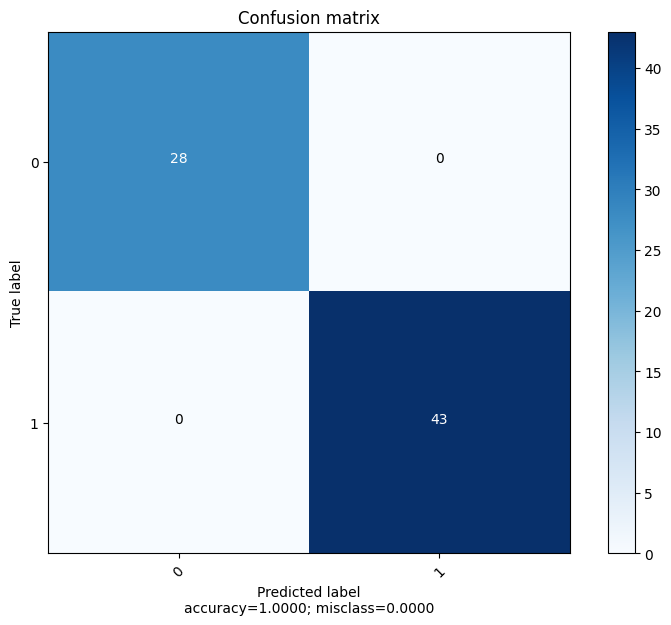

In [85]:
y_pred = model.predict(test_dataset.X_data, binary=binary)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

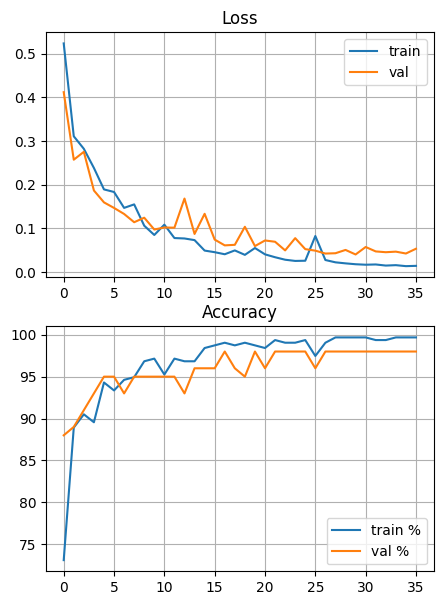

In [86]:
plot_loss_acc(history)

Neste caso podemos inferir que durante o treinamento da rede a cada época o desempenho da rede é avaliado no conjunto de validação, quando o desempenho no conjunto de validação começar a piorar isto significa que a rede está começando a perder sua capacidade de generalização. Nesse ponto, a parada antecipada ou 'early stopping' é acionada em 19 épocas e o treinamento é interrompido. A rede neural é salva no momento em que o desempenho no conjunto de validação é melhor.

### 2)	Faça novos testes para avaliar o desempenho da Rede Neural no problema designado usando a técnica K-Fold (com K = 10). Comente o resultado obtido.

Dica: não é necessário utilizar a ferramenta KFold do scikit-learn para o desenvolvimento deste item. Uma alternativa <b> simples </b> é fazer um *for loop*, selecionando os índices em bloco. 

![Alt text](0SQJq.png)

#### Rascunho

In [87]:
new_df = transform_data(dataset, normalize=False)

In [88]:
X = new_df.values[:,:-1].astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)

n_input = X.shape[1]

if np.unique(y).shape[0] <= 2:
  print('Binary classification')
  n_output = 1

else:
  print('Multiclass classification')
  #y = to_categorical(y)
  n_output = encoder.classes_.shape[0]
  
  #X, X_val, y, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


Binary classification


In [89]:
if binary:
    kfold_dataset = CustomDataset(torch.from_numpy(X).float(), torch.from_numpy(y).float().unsqueeze(1))
    #val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
else:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())
#val_loader = DataLoader(dataset=val_dataset, batch_size=1)

In [90]:
k = 10
lr = 0.01
epochs = 50
batch_size = 1
kfold = KFold(n_splits=k, shuffle=True, random_state=42)


In [91]:
from train_kfold import train_kfold

In [92]:
acc_sum = 0
loss_sum = 0
for fold, (k_train, k_val) in enumerate(kfold.split(kfold_dataset)):
    print(f'Fold {fold+1}')
    print('-------------------')
    train_sampler = torch.utils.data.SubsetRandomSampler(k_train)
    val_sampler = torch.utils.data.SubsetRandomSampler(k_val)
    
    train_loader = DataLoader(kfold_dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(kfold_dataset, batch_size=batch_size, sampler=val_sampler)
    
    model = NeuralNetwork(hidden_neurons = 4, n_input = n_input, n_output=n_output,output_activation='sigmoid')
    
    history, y_hat = train_kfold(model, train_loader, val_loader, epochs=epochs, lr=lr, device=device, binary=binary, skip=epochs)
    acc_sum += history['acc_val'][-1]
    loss_sum += history['loss_val'][-1]
print(f'Average val loss: {loss_sum:.4f}, Average val accuracy: {acc_sum:.4f}')

Fold 1
-------------------


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 050: | Train Loss: 0.087 | Val Loss: 0.0310 | Train Acc: 97.4603| Val Acc: 8.8319
Fold 2
-------------------


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 050: | Train Loss: 0.078 | Val Loss: 0.0306 | Train Acc: 98.1013| Val Acc: 9.1168
Fold 3
-------------------


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 050: | Train Loss: 0.091 | Val Loss: 0.0082 | Train Acc: 97.7848| Val Acc: 9.4017
Fold 4
-------------------


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 050: | Train Loss: 0.104 | Val Loss: 0.0410 | Train Acc: 96.8354| Val Acc: 9.1168
Fold 5
-------------------


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 050: | Train Loss: 0.077 | Val Loss: 0.0230 | Train Acc: 97.4684| Val Acc: 8.8319
Fold 6
-------------------


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 050: | Train Loss: 0.105 | Val Loss: 0.0460 | Train Acc: 95.5696| Val Acc: 8.8319
Fold 7
-------------------


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 050: | Train Loss: 0.085 | Val Loss: 0.0352 | Train Acc: 96.8354| Val Acc: 8.5470
Fold 8
-------------------


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 050: | Train Loss: 0.083 | Val Loss: 0.0159 | Train Acc: 98.1013| Val Acc: 9.4017
Fold 9
-------------------


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 050: | Train Loss: 0.080 | Val Loss: 0.0411 | Train Acc: 97.7848| Val Acc: 9.1168
Fold 10
-------------------


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 050: | Train Loss: 0.078 | Val Loss: 0.0288 | Train Acc: 98.1013| Val Acc: 9.1168
Average val loss: 0.3008, Average val accuracy: 90.3134


#### Resposta

Para avaliar o desempenho dos modelos em um conjunto de dados, precisamos medir o quão bem as previsões feitas pelo modelo correspondem aos dados observados. A maneira mais comum de medir isso é usando o erro quadrático médio (MSE). O teste MSE nos dá uma ideia de como um modelo funcionará em dados que não viu anteriormente. No entanto, a desvantagem de usar apenas um conjunto de teste é que o MSE de teste pode variar muito, dependendo de quais observações foram usadas nos conjuntos de treinamento e teste.

Uma maneira de evitar esse problema é utilizar validação cruzada k-fold. É uma técnica de reamostragem que pode ser usada para avaliar um modelo em um conjunto de dados. A validação cruzada k-fold divide aleatoriamente um conjunto de dados em k grupos ou dobras de tamanhos iguais. Cada dobra é usada uma vez como um conjunto de testes enquanto as dobras restantes formam o conjunto de treinamento. Em seguida, a média dos erros de teste é calculada para fornecer uma estimativa mais precisa do desempenho do modelo no conjunto de dados. 

Quando dividimos um conjunto de dados em apenas um conjunto de treinamento e um conjunto de teste, o teste MSE calculado sobre as observações no conjunto de teste pode variar muito, dependendo de quais observações foram usadas nos conjuntos de treinamento e teste. Ao usar a validação cruzada k-fold, podemos calcular o MSE de teste usando diversas variações diferentes de conjuntos de treinamento e teste. Isso torna muito mais provável obtermos uma estimativa imparcial do teste MSE.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       1.00      1.00      1.00        43

    accuracy                           1.00        71
   macro avg       1.00      1.00      1.00        71
weighted avg       1.00      1.00      1.00        71



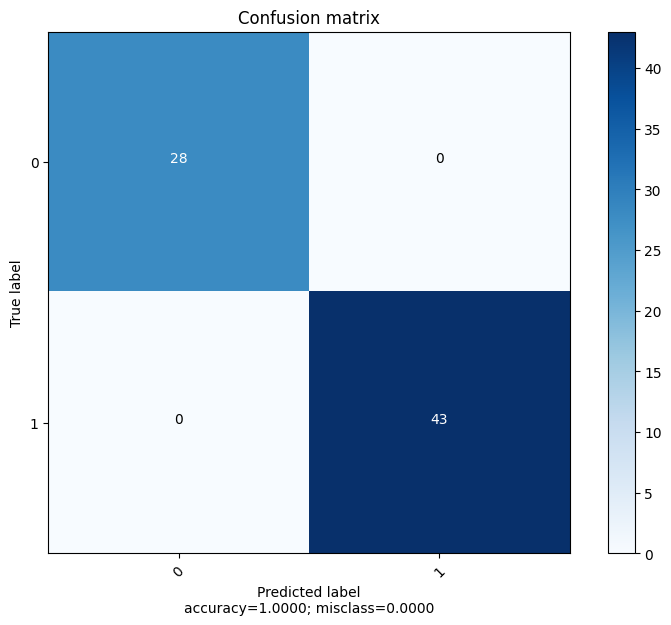

In [93]:
y_pred = model.predict(test_dataset.X_data, binary=binary)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

A matriz de confussão permite uma análise mais detalhada voltada para modelos de classificação e tem como objetivo calcular a quantidade de falso positivo e falso negativo; e de verdadeiro positivo e verdadeiro negativo, além de te fornecer a acurácia e sensibilidade. De acordo com o anterior, neste modelo temos uma accuracy de 98% isso quer dizer que foi um bom treinamento, sendo que o f1-score é 0,98 e 0,99.

Alem disso, no grafico das curvas do aprendizado podemos observar que o modelo apresenta um 'optimal fit', pois a curva de treinamento e a curva de validação estão convergindo para um valor baixo de erro, e a curva de validação não está muito distante da curva de treinamento, o que indica que o modelo não está sofrendo de overfitting. Pode ser identificada através da obtenção de valores de perda nos dados de validação que não diferem muito das perdas nos dados de treino.

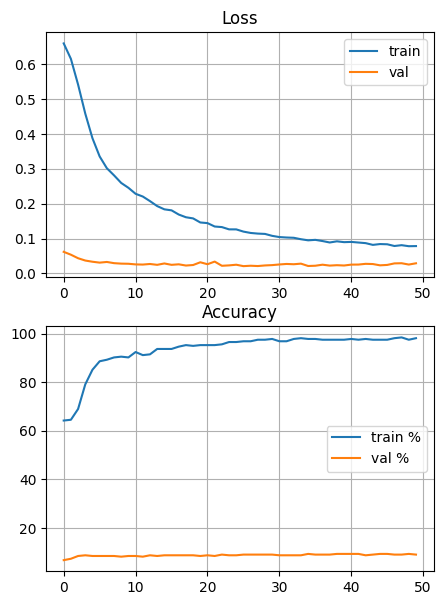

In [94]:
plot_loss_acc(history)

### 3)	Faça análises e novas implementações que você julgue importante para o seu trabalho. Não esqueça de explicar a motivação da análise realizada. 

#### Rascunho

In [95]:
# Principal component analysis (PCA)
from sklearn.decomposition import PCA

In [96]:
X = new_df.values[:,:-1].astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)

n_input = X.shape[1]

if np.unique(y).shape[0] <= 2:
  print('Binary classification')
  n_output = 1

else:
  print('Multiclass classification')
  #y = to_categorical(y)
  n_output = encoder.classes_.shape[0]
print(f"X before PCA: {X.shape}")
X = PCA(n_components=10).fit_transform(X)
print(f"X results with PCA: {X.shape}")
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)

Binary classification
X before PCA: (351, 33)
X results with PCA: (351, 10)


In [97]:
if binary:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
else:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [99]:
lr = 0.01
epochs = 250
n_input = X.shape[1]
model = NeuralNetwork(n_input = n_input, n_output=n_output,output_activation='sigmoid')
history, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary, skip=epochs)

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 250: | Train Loss: 0.098 | Val Loss: 0.5740 | Train Acc: 95.0893| Val Acc: 84.0000


#### Resposta


A análise de componentes principais (PCA) é um dos algoritmos de aprendizagem automática não supervisionada mais utilizados numa variedade de aplicações: análise exploratória de dados, redução da dimensionalidade, compressão de informação, eliminação de ruído de dados e muito mais. PCA é um algoritmo de redução de dimensionalidade que pode ser usado para reduzir um grande conjunto de atributos (variáveis) para um conjunto menor que ainda contém a maior parte da informação nos dados originais.

A redução da dimensionalidade linear utiliza a decomposição do valor singular dos dados para os projectar num espaço de dimensão inferior. Os dados de entrada são centrados, mas não escalados, para cada característica antes de aplicar a SVD.

Portanto, para reduzir a dimensionalidade do conjunto de dados foi utilizada PCA, uma vez que se observa que existe uma elevada correlação entre os diferentes atributos, por exemplo: se é analisado o heatmap do rascunho 'info 10' e 'info_8' , 'info_14' e 'info_12' é igual a 0,83. Aliás, existe colinearidade entre as variáveis, por tanto, seria uma boa opção a redução de dimensionalidade porque é capaz de simplificar modelos, reduzir o tempo de treino.

              precision    recall  f1-score   support

           0       0.95      0.68      0.79        28
           1       0.82      0.98      0.89        43

    accuracy                           0.86        71
   macro avg       0.89      0.83      0.84        71
weighted avg       0.87      0.86      0.85        71



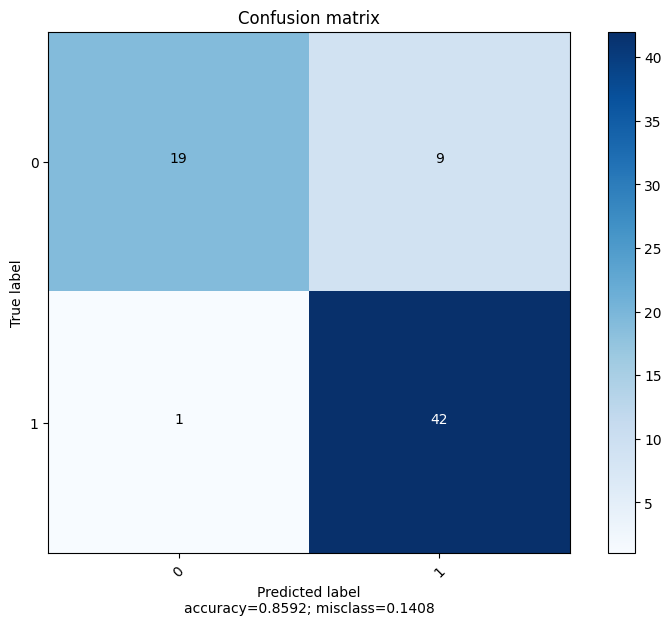

In [100]:
y_pred = model.predict(test_dataset.X_data, binary=binary)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

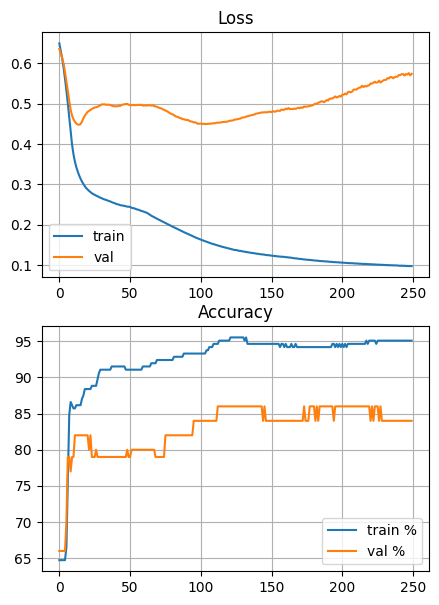

In [101]:
plot_loss_acc(history)